# Integration: MaxFuse and MARIO

This notebook performs cross-modal integration of RNA-seq and CODEX protein data.

## Recommended Workflow

**For cross-modal data (RNA + Protein/CODEX):**
1. Run Steps 1-4 (data loading and preparation)
2. **Skip** MARIO section (designed for same-modality data)
3. Run **MaxFuse Integration** (Step 7+)

**For same-modality data (e.g., CITE-seq + CyTOF):**
1. Run all steps including MARIO

## What Each Method Does

| Method | Best For | Key Feature |
|--------|----------|-------------|
| **MaxFuse** | Cross-modal (RNA↔Protein) | Handles weak feature linkage |
| **MARIO** | Same-modality (Protein↔Protein) | Statistical matchability test |


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import json
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.io import mmread

# MaxFuse imports
import maxfuse as mf
from maxfuse import Fusor, Mario
from maxfuse.mario import pipelined_mario

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load preprocessed data from 1_preprocessing.ipynb
# Run 1_preprocessing.ipynb first to generate these files

import os

# Fix working directory if notebook started from wrong location
# The notebook expects to run from the notebooks/ directory
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
if not os.path.exists('../results/1_preprocessing') and os.path.exists('/home/smith6jt/maxfuse/results/1_preprocessing'):
    os.chdir('/home/smith6jt/maxfuse/notebooks')
    print(f"Changed working directory to: {os.getcwd()}")

results_dir = '../results/1_preprocessing'

if not os.path.exists(results_dir):
    raise FileNotFoundError(
        f"Results directory '{results_dir}' not found. "
        f"Run 1_preprocessing.ipynb first to generate the input files."
    )

# Load processed AnnData objects
protein_adata = sc.read_h5ad(f'{results_dir}/protein_adata.h5ad')
rna_adata = sc.read_h5ad(f'{results_dir}/rna_adata.h5ad')
rna_adata_lognorm = sc.read_h5ad(f'{results_dir}/rna_adata_lognorm.h5ad')

print(f"Loaded from {results_dir}/")
print(f"  Protein data: {protein_adata.shape}")
print(f"  RNA data: {rna_adata.shape}")
print(f"  RNA log-normalized: {rna_adata_lognorm.shape}")

# Load preprocessing parameters
with open(f'{results_dir}/preprocessing_params.json', 'r') as f:
    preprocess_params = json.load(f)
print(f"\nPreprocessing timestamp: {preprocess_params['timestamp']}")

Changed working directory to: /home/smith6jt/maxfuse/notebooks
Loaded from ../results/1_preprocessing/
  Protein data: (1740774, 59)
  RNA data: (1284, 15887)
  RNA log-normalized: (1284, 15887)

Preprocessing timestamp: 2026-01-16T14:47:28.211987


## Step 3: Build Protein-Gene Correspondence

Map CODEX protein markers to their corresponding gene names in the RNA data.

In [3]:
# Load correspondence table
correspondence = pd.read_csv('../data/protein_gene_conversion.csv', encoding='utf-8-sig')
print(f"Correspondence table: {correspondence.shape[0]} entries")
correspondence.head(10)

Correspondence table: 370 entries


,Protein name,RNA name
0,CD80,CD80
1,CD86,CD86
2,CD274,CD274
3,CD273,PDCD1LG2
4,CD275,ICOSLG
5,CD275-1,ICOSLG
6,CD275-2,ICOSLG
7,CD11b,ITGAM
8,CD11b-1,ITGAM
9,CD11b-2,ITGAM


In [4]:
# Find matching features between CODEX markers and RNA genes
# Define markers to exclude (non-immune, structural, or problematic for CD45+ RNA data)
EXCLUDED_MARKERS = [
    'DAPI',           # Nuclear stain
    'ECAD', 'E-cadherin',  # Epithelial
    'IAPP', 'INS', 'GCG', 'SST',  # Pancreatic endocrine
    'Ker8-18', 'Pan-Cytokeratin', 'Keratin 5', 'EpCAM', 'TP63',  # Epithelial
    'Collagen IV', 'Vimentin', 'SMA', 'Caveolin',  # Stromal/structural
    'CD31', 'Podoplanin',  # Endothelial/lymphatic
    'Beta-actin',     # Housekeeping
    'LAG3',          # Excluded per user
]

rna_protein_correspondence = []
unmatched_proteins = []

for marker in protein_adata.var_names:
    # Skip excluded markers
    if marker in EXCLUDED_MARKERS:
        continue
    
    # Look up in correspondence table
    matches = correspondence[correspondence['Protein name'].str.lower() == marker.lower()]
    
    if len(matches) == 0:
        # Try alternative names
        alt_names = {
            'CD3e': 'CD3',
            'FoxP3': 'FOXP3',
            'HLADR': 'HLA-DR',
            'Lyve1': 'LYVE1',
            'SMActin': 'SMA',
            'CollagenIV': 'collagen IV',
        }
        alt_marker = alt_names.get(marker, marker)
        matches = correspondence[correspondence['Protein name'].str.lower() == alt_marker.lower()]
    
    if len(matches) > 0:
        rna_names_str = matches.iloc[0]['RNA name']
        if 'Ignore' in str(rna_names_str):
            unmatched_proteins.append((marker, 'Ignored'))
            continue
        
        # Try each RNA name option
        found = False
        for rna_name in str(rna_names_str).split('/'):
            if rna_name in rna_adata.var_names:
                rna_protein_correspondence.append([rna_name, marker])
                found = True
                break
        if not found:
            unmatched_proteins.append((marker, rna_names_str))
    else:
        unmatched_proteins.append((marker, 'Not in table'))

rna_protein_correspondence = np.array(rna_protein_correspondence)
print(f"Found {len(rna_protein_correspondence)} protein-gene pairs")
print(f"Excluded {len(EXCLUDED_MARKERS)} non-immune/structural markers")

if unmatched_proteins:
    print(f"\nUnmatched proteins ({len(unmatched_proteins)}):")
    for prot, reason in unmatched_proteins:
        print(f"  {prot}: {reason}")

Found 40 protein-gene pairs
Excluded 20 non-immune/structural markers


In [5]:
# Remove duplicates (same RNA mapping to multiple proteins)
# Keep first occurrence
seen_rna = set()
unique_pairs = []
for rna, prot in rna_protein_correspondence:
    if rna not in seen_rna:
        seen_rna.add(rna)
        unique_pairs.append([rna, prot])
    else:
        print(f"Removing duplicate RNA mapping: {rna} -> {prot}")

rna_protein_correspondence = np.array(unique_pairs)
print(f"\nFinal correspondence: {len(rna_protein_correspondence)} pairs")

print("\nMatched features:")
for rna, prot in rna_protein_correspondence:
    print(f"  {rna:15} <-> {prot}")


Final correspondence: 40 pairs

Matched features:
  LAMP1           <-> CD107a
  CD4             <-> CD4
  CD68            <-> CD68
  CD44            <-> CD44
  CD99            <-> CD99
  IDO1            <-> IDO1
  CEACAM1         <-> CD66
  ITGAX           <-> CD11c
  CD38            <-> CD38
  HLA-DRA         <-> HLA-DR
  CD34            <-> CD34
  NOS2            <-> iNOS
  LGALS3          <-> M2Gal3
  TUBB3           <-> B3TUBB
  CD8A            <-> CD8
  PCNA            <-> PCNA
  FOXP3           <-> FOXP3
  B3GAT1          <-> CD57
  MKI67           <-> Ki67
  GZMB            <-> Granzyme B
  HLA-A           <-> HLA-A
  MS4A1           <-> CD20
  VSIR            <-> VISTA
  PDCD1           <-> PD-1
  TCF7            <-> TCF-1
  TOX             <-> TOX
  ICOS            <-> ICOS
  CD163           <-> CD163
  CD274           <-> PD-L1
  CD79A           <-> CD79a
  CD3E            <-> CD3e
  BCL2            <-> Bcl-2
  MPO             <-> MPO
  NCAM1           <-> CD56
  ENTPD1    

## Step 4: Prepare Arrays for Integration

Extract and normalize:
- **Shared arrays**: Corresponding protein/gene features (used for initial matching)
- **Active arrays**: All features (used for refinement)

In [12]:
# Extract shared features from FILTERED data
# Create AnnData objects for shared features to use with scanpy normalization

# Get the gene/protein names from correspondence
shared_rna_genes = rna_protein_correspondence[:, 0]  # RNA gene names
shared_protein_markers = rna_protein_correspondence[:, 1]  # Protein marker names

# Verify all features exist
missing_rna = [g for g in shared_rna_genes if g not in rna_adata.var_names]
missing_prot = [p for p in shared_protein_markers if p not in protein_adata.var_names]

if missing_rna:
    print(f"WARNING: Missing RNA genes: {missing_rna}")
if missing_prot:
    print(f"WARNING: Missing protein markers: {missing_prot}")

# Create shared feature AnnData objects
rna_shared_adata = rna_adata[:, shared_rna_genes].copy()
protein_shared_adata = protein_adata[:, shared_protein_markers].copy()

print(f"Shared feature AnnData objects created:")
print(f"  rna_shared_adata: {rna_shared_adata.shape}")
print(f"  protein_shared_adata: {protein_shared_adata.shape}")
print(f"\nRNA shared features: {list(rna_shared_adata.var_names[:5])}...")
print(f"Protein shared features: {list(protein_shared_adata.var_names[:5])}...")

Shared feature AnnData objects created:
  rna_shared_adata: (1284, 40)
  protein_shared_adata: (1740774, 40)

RNA shared features: ['LAMP1', 'CD4', 'CD68', 'CD44', 'CD99']...
Protein shared features: ['CD107a', 'CD4', 'CD68', 'CD44', 'CD99']...


In [13]:
# Normalize shared features
# KEY INSIGHT: RNA and protein have DIFFERENT data characteristics
# - RNA: Sparse (many true zeros = undetected), needs detection-aware normalization
# - Protein: Continuous (no true zeros, just low expression), needs standard z-score

from scipy import sparse, stats
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ============================================================
# EXTRACT RAW DATA
# ============================================================

rna_shared_raw = rna_shared_adata.X.copy()
if sparse.issparse(rna_shared_raw):
    rna_shared_raw = rna_shared_raw.toarray()

protein_shared_raw = protein_shared_adata.X.copy()
if sparse.issparse(protein_shared_raw):
    protein_shared_raw = protein_shared_raw.toarray()

print("=" * 70)
print("SHARED FEATURE NORMALIZATION")
print("=" * 70)
print(f"\nCell counts: RNA = {rna_shared_raw.shape[0]:,}, Protein = {protein_shared_raw.shape[0]:,}")

# Fixed value for RNA undetected values
ZERO_VALUE = -3.0

# ============================================================
# LOAD GATES FOR PROTEIN DETECTION (for visualization only)
# ============================================================

gates = protein_adata.uns['gates']
protein_log_layer = protein_adata.layers['log']

shared_marker_names = [prot_name for rna_name, prot_name in rna_protein_correspondence]

# Extract log values for gate-based detection (used for visualization)
protein_log_shared = np.zeros((protein_shared_adata.n_obs, len(shared_marker_names)))
protein_gates = np.zeros(len(shared_marker_names))

for i, marker in enumerate(shared_marker_names):
    if marker in protein_adata.var_names:
        marker_idx = list(protein_adata.var_names).index(marker)
        protein_log_shared[:, i] = protein_log_layer[:, marker_idx]
        if marker in gates.index:
            protein_gates[i] = gates.loc[marker, 'gates']
        else:
            protein_gates[i] = np.median(protein_log_shared[:, i])

# Detection mask for protein (gate-based) - used for visualization
protein_detection_mask = protein_log_shared > protein_gates[np.newaxis, :]

print("\n" + "="*70)
print("PROTEIN DETECTION RATES (gate-based, for reference)")
print("="*70)
print(f"{'Marker':<12} {'Gate':>8} {'% Positive':>12}")
print("-"*34)
for i, (rna_name, prot_name) in enumerate(rna_protein_correspondence[:10]):
    det_rate = protein_detection_mask[:, i].mean() * 100
    print(f"{prot_name[:11]:<12} {protein_gates[i]:>8.2f} {det_rate:>11.1f}%")
if len(rna_protein_correspondence) > 10:
    print("...")

# ============================================================
# RNA NORMALIZATION: Detection-Aware (sparse data with true zeros)
# ============================================================

print("\n" + "="*70)
print("RNA NORMALIZATION (Detection-Aware for Sparse Data)")
print("="*70)
print(f"  Raw zeros: {(rna_shared_raw == 0).mean()*100:.1f}%")

# Step 1: Library size normalization
sc.pp.normalize_total(rna_shared_adata, target_sum=1e4)

# Step 2: Log transform
sc.pp.log1p(rna_shared_adata)
rna_after_log = rna_shared_adata.X.copy()
if sparse.issparse(rna_after_log):
    rna_after_log = rna_after_log.toarray()

# RNA detection mask: non-zero after log1p (true biological zeros)
rna_detection_mask = rna_after_log > 0
print(f"  After log1p: {rna_detection_mask.mean()*100:.1f}% detected (non-zero)")

# Detection-aware normalization for RNA
def detection_aware_normalize_rna(data, detection_mask, zero_value=ZERO_VALUE):
    """Z-score detected values only, set undetected to fixed value."""
    n_cells, n_features = data.shape
    normalized = np.full_like(data, zero_value, dtype=np.float64)
    
    for j in range(n_features):
        detected_idx = detection_mask[:, j]
        if detected_idx.sum() > 1:
            vals = data[detected_idx, j]
            z_vals = (vals - vals.mean()) / (vals.std() + 1e-8)
            z_vals = np.clip(z_vals, -5, 5)
            normalized[detected_idx, j] = z_vals
    
    return normalized

rna_shared_normalized = detection_aware_normalize_rna(rna_after_log, rna_detection_mask)

# Stats for detected values only
rna_detected_vals = rna_shared_normalized[rna_detection_mask]
print(f"\n  Detected values: mean={rna_detected_vals.mean():.4f}, std={rna_detected_vals.std():.4f}")
print(f"  Undetected set to: {ZERO_VALUE}")

# ============================================================
# PROTEIN NORMALIZATION: Standard Z-score (continuous data)
# ============================================================

print("\n" + "="*70)
print("PROTEIN NORMALIZATION (Standard Z-score for Continuous Data)")
print("="*70)
print(f"  Shape: {protein_shared_raw.shape}")
print(f"  Raw: mean={protein_shared_raw.mean():.3f}, std={protein_shared_raw.std():.3f}")

# Standard z-score on ALL values (protein is continuous, not sparse)
scaler = StandardScaler()
protein_shared_normalized = scaler.fit_transform(protein_shared_raw)
protein_shared_normalized = np.clip(protein_shared_normalized, -5, 5)

print(f"\n  After z-score: mean={protein_shared_normalized.mean():.4f}, std={protein_shared_normalized.std():.4f}")
print(f"  Range: [{protein_shared_normalized.min():.2f}, {protein_shared_normalized.max():.2f}]")

# ============================================================
# STORE RESULTS
# ============================================================

# Final normalized arrays
rna_shared = rna_shared_normalized.astype(np.float32)
protein_shared = protein_shared_normalized.astype(np.float32)

# Compatibility names
rna_shared_after_scale = rna_shared
protein_shared_after = protein_shared

# Update AnnData objects
rna_shared_adata.X = rna_shared
protein_shared_adata.X = protein_shared

# ============================================================
# VERIFICATION
# ============================================================

print("\n" + "="*70)
print("VERIFICATION")
print("="*70)

print("\nRNA (detected values only):")
print(f"  mean={rna_detected_vals.mean():.4f}, std={rna_detected_vals.std():.4f}")

print("\nProtein (all values):")
print(f"  mean={protein_shared.mean():.4f}, std={protein_shared.std():.4f}")

print("\n" + "="*70)
print("SUCCESS: Normalization complete!")
print("- RNA: Detection-aware (zeros → fixed value, detected → z-score)")
print("- Protein: Standard z-score on all values (continuous data)")
print("="*70)

SHARED FEATURE NORMALIZATION

Cell counts: RNA = 1,284, Protein = 1,740,774

PROTEIN DETECTION RATES (gate-based, for reference)
Marker           Gate   % Positive
----------------------------------
CD107a           5.60        19.8%
CD4              6.90         3.7%
CD68             5.20         4.5%
CD44             6.90        17.5%
CD99             7.50         1.4%
IDO1             5.00         3.5%
CD66             5.90         0.5%
CD11c            5.70         1.9%
CD38             6.50         0.1%
HLA-DR           5.50         1.6%
...

RNA NORMALIZATION (Detection-Aware for Sparse Data)
  Raw zeros: 87.7%
  After log1p: 12.3% detected (non-zero)

  Detected values: mean=-0.0009, std=1.0013
  Undetected set to: -3.0

PROTEIN NORMALIZATION (Standard Z-score for Continuous Data)
  Shape: (1740774, 40)
  Raw: mean=0.411, std=0.077

  After z-score: mean=-0.0044, std=0.9669
  Range: [-5.00, 5.00]

VERIFICATION

RNA (detected values only):
  mean=-0.0009, std=1.0013

Protein (all

Example feature: HLA-DRA / HLA-DR
  RNA detection: 29.7% (381 cells)
  Protein detection (gate-based): 1.6% (27,351 cells)


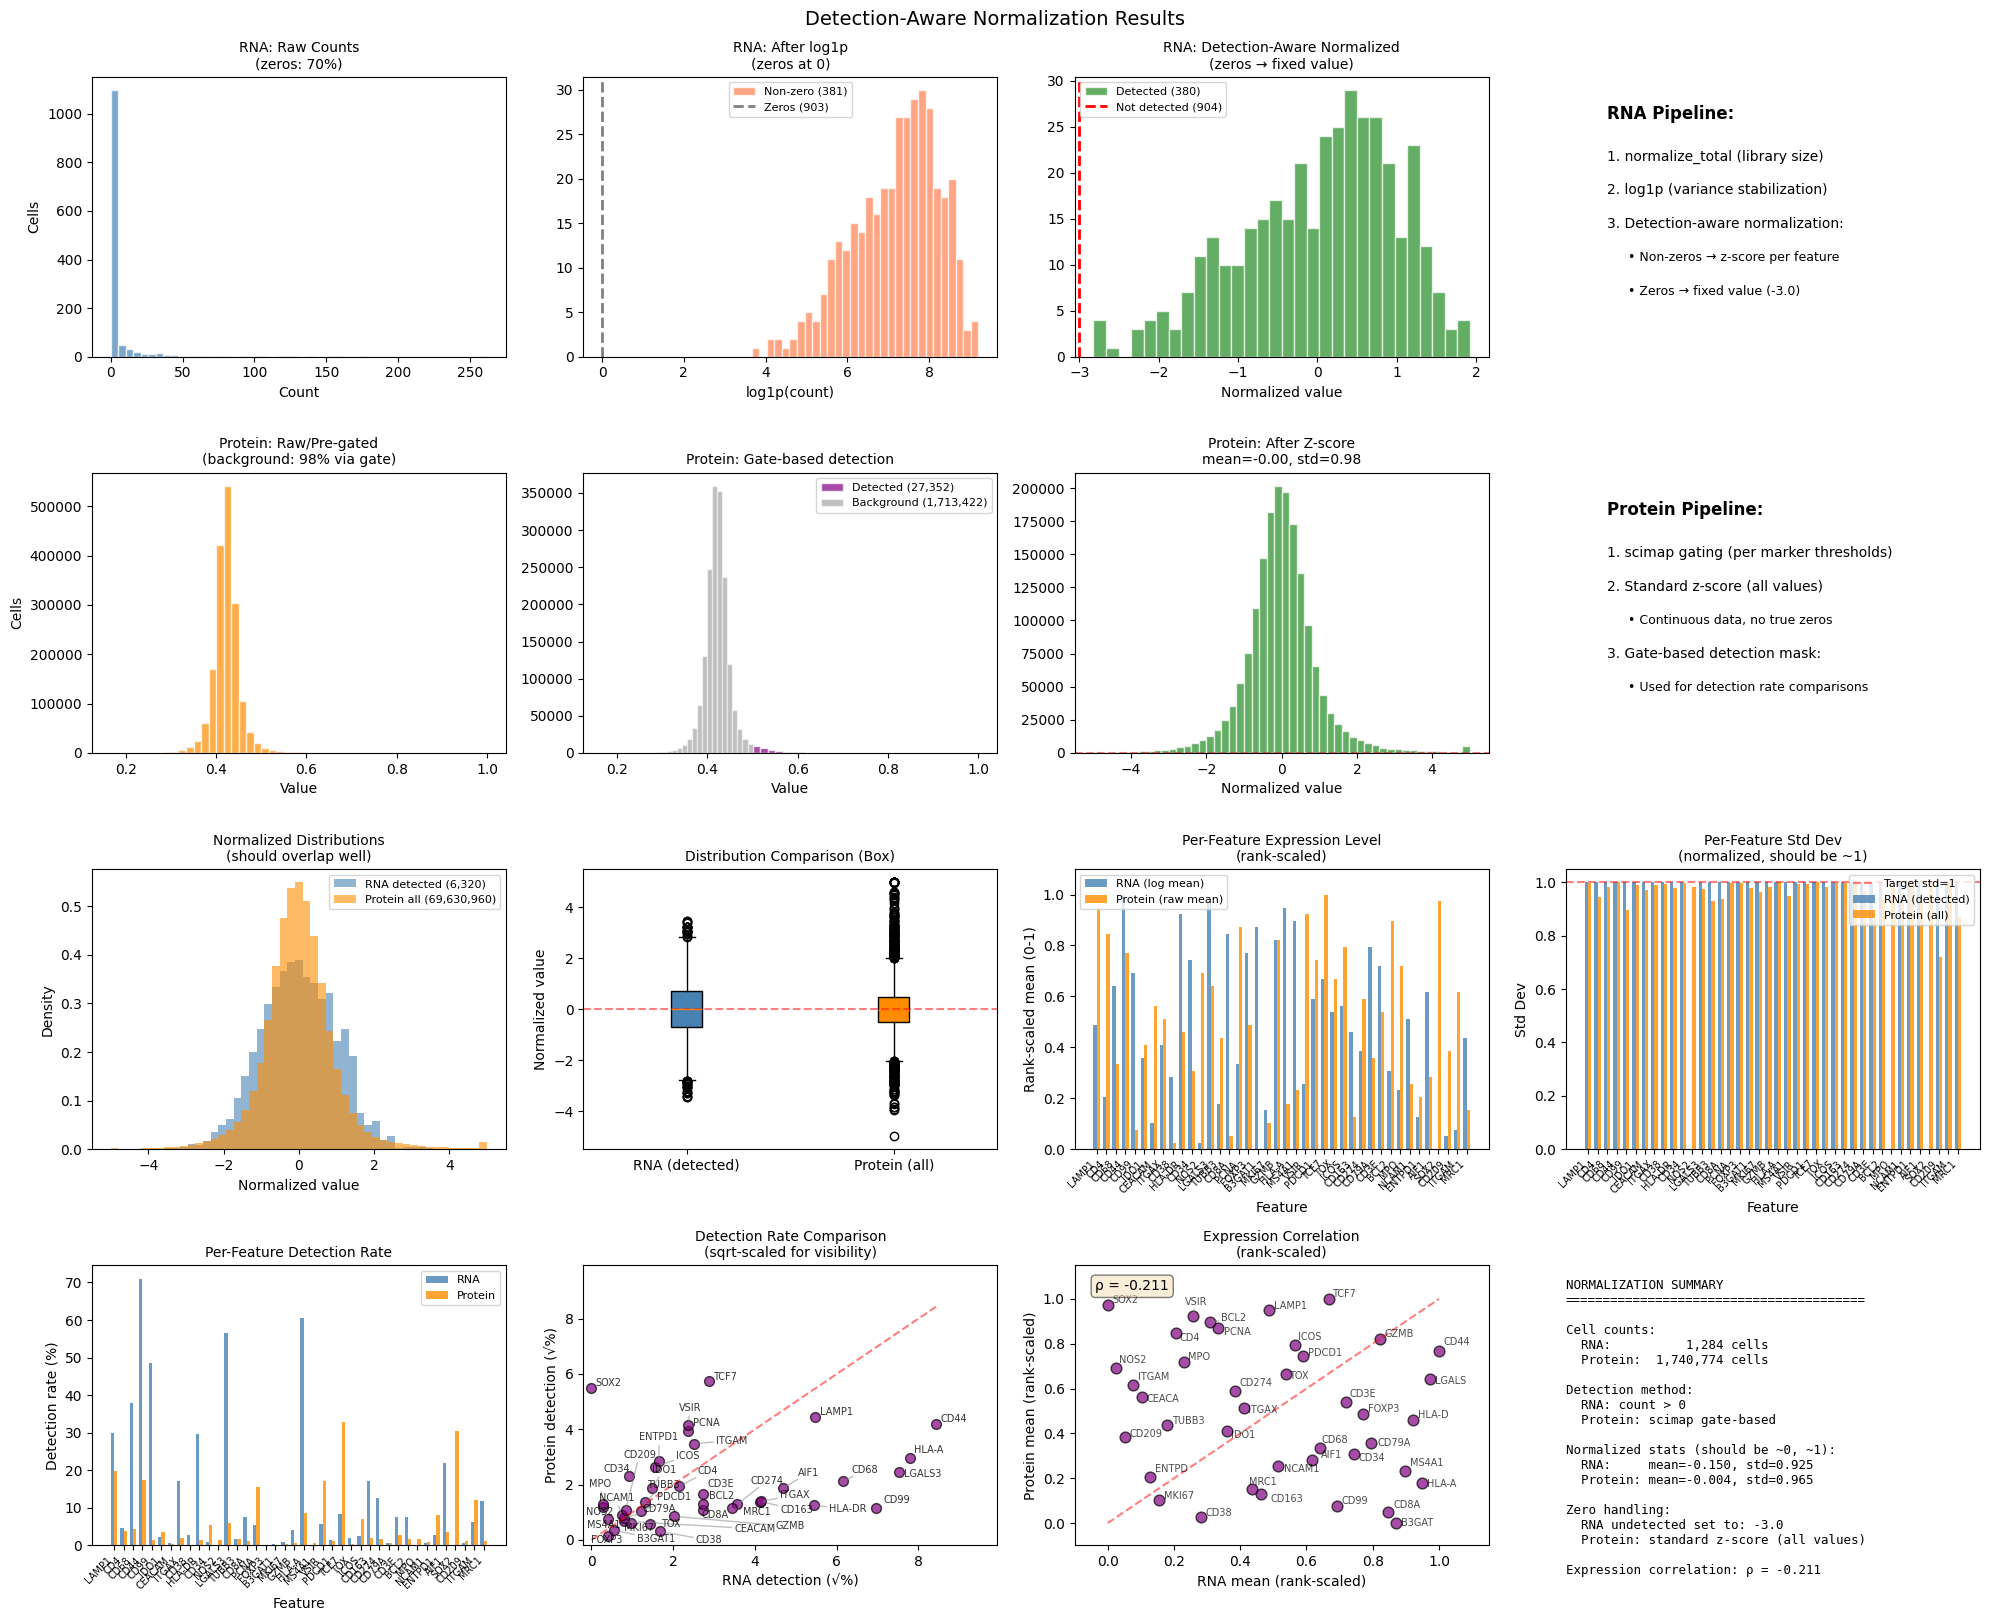


KEY INSIGHT:
RNA detection: count > 0 (sparse data)
Protein detection: scimap gate-based (continuous data)
Both normalized to ~N(0,1) for matching.

Expression correlation: Spearman ρ = -0.211 (p = 1.91e-01)


In [14]:
# Visualize DETECTION-AWARE normalization
# Updated to use 4x4 grid matching the working visualization.py

# SANITY CHECK: Detect if old cached values are being used
prot_at_minus3 = np.abs(protein_shared - (-3.0)) < 0.1
if prot_at_minus3.mean() > 0.1:
    print("="*70)
    print("WARNING: Protein data appears to have old cached values!")
    print(f"  {prot_at_minus3.mean()*100:.1f}% of values are near -3.0")
    print("  FIX: Restart kernel and re-run all cells from the beginning")
    print("="*70)
    raise RuntimeError("Please restart kernel and re-run all cells")

from scipy.stats import rankdata, spearmanr

fig, axes = plt.subplots(4, 4, figsize=(20, 16))

feature_names = list(rna_protein_correspondence[:, 0])
protein_names = list(rna_protein_correspondence[:, 1])
n_features = rna_shared.shape[1]

# Define x_pos and width for bar charts
x_pos = np.arange(n_features)
width = 0.35

# Pick a feature with moderate expression for detailed view
detection_rates_rna = [rna_detection_mask[:, i].mean() for i in range(n_features)]
good_features = [i for i, d in enumerate(detection_rates_rna) if 0.2 < d < 0.8]
if good_features:
    best_feat_idx = good_features[len(good_features)//2]
else:
    best_feat_idx = np.argmax(detection_rates_rna)
feat_name = feature_names[best_feat_idx]
prot_name = protein_names[best_feat_idx]

# Detection rates
rna_det_rates = [rna_detection_mask[:, i].mean() * 100 for i in range(n_features)]
prot_det_rates = [protein_detection_mask[:, i].mean() * 100 for i in range(n_features)]

rna_det = rna_det_rates[best_feat_idx]
prot_det = prot_det_rates[best_feat_idx]

# Compute PRE-NORMALIZATION means for the bar chart and scatter plots
# These are meaningful values (not z-scored to 0)
rna_log_means = []
prot_raw_means = []
for i in range(n_features):
    detected = rna_detection_mask[:, i]
    if detected.sum() > 0:
        rna_log_means.append(rna_after_log[detected, i].mean())
    else:
        rna_log_means.append(0)
    prot_raw_means.append(protein_shared_raw[:, i].mean())
rna_log_means = np.array(rna_log_means)
prot_raw_means = np.array(prot_raw_means)

# Also compute POST-NORMALIZATION means/stds for QC
rna_means_norm = []
prot_means_norm = []
rna_stds_norm = []
prot_stds_norm = []
for i in range(n_features):
    rna_det_vals = rna_shared[rna_detection_mask[:, i], i]
    rna_means_norm.append(rna_det_vals.mean() if len(rna_det_vals) > 0 else 0)
    rna_stds_norm.append(rna_det_vals.std() if len(rna_det_vals) > 1 else 0)
    prot_means_norm.append(protein_shared[:, i].mean())
    prot_stds_norm.append(protein_shared[:, i].std())

print(f"Example feature: {feat_name} / {prot_name}")
print(f"  RNA detection: {rna_det:.1f}% ({int(rna_det/100 * rna_shared.shape[0]):,} cells)")
print(f"  Protein detection (gate-based): {prot_det:.1f}% ({int(prot_det/100 * protein_shared.shape[0]):,} cells)")

# ============================================================
# Row 1: RNA transformation pipeline
# ============================================================
ax = axes[0, 0]
raw_vals = rna_shared_raw[:, best_feat_idx]
ax.hist(raw_vals, bins=50, alpha=0.7, color='steelblue', edgecolor='white')
ax.set_title(f'RNA: Raw Counts\n(zeros: {(raw_vals==0).mean()*100:.0f}%)', fontsize=10)
ax.set_xlabel('Count')
ax.set_ylabel('Cells')

ax = axes[0, 1]
log_vals = rna_after_log[:, best_feat_idx]
zeros = log_vals == 0
nonzeros = ~zeros
ax.hist(log_vals[nonzeros], bins=30, alpha=0.7, color='coral', edgecolor='white', label=f'Non-zero ({nonzeros.sum():,})')
if zeros.sum() > 0:
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=2, label=f'Zeros ({zeros.sum():,})')
ax.set_title('RNA: After log1p\n(zeros at 0)', fontsize=10)
ax.set_xlabel('log1p(count)')
ax.legend(fontsize=8)

ax = axes[0, 2]
norm_vals = rna_shared[:, best_feat_idx]
nonzero_mask = norm_vals > ZERO_VALUE + 0.1
ax.hist(norm_vals[nonzero_mask], bins=30, alpha=0.7, color='forestgreen', edgecolor='white', 
        label=f'Detected ({nonzero_mask.sum():,})')
ax.axvline(x=ZERO_VALUE, color='red', linestyle='--', linewidth=2, 
           label=f'Not detected ({(~nonzero_mask).sum():,})')
ax.set_title('RNA: Detection-Aware Normalized\n(zeros → fixed value)', fontsize=10)
ax.set_xlabel('Normalized value')
ax.legend(fontsize=8)

ax = axes[0, 3]
ax.axis('off')
ax.text(0.1, 0.85, 'RNA Pipeline:', fontsize=12, fontweight='bold', transform=ax.transAxes)
ax.text(0.1, 0.70, '1. normalize_total (library size)', fontsize=10, transform=ax.transAxes)
ax.text(0.1, 0.58, '2. log1p (variance stabilization)', fontsize=10, transform=ax.transAxes)
ax.text(0.1, 0.46, '3. Detection-aware normalization:', fontsize=10, transform=ax.transAxes)
ax.text(0.15, 0.34, '• Non-zeros → z-score per feature', fontsize=9, transform=ax.transAxes)
ax.text(0.15, 0.22, f'• Zeros → fixed value ({ZERO_VALUE})', fontsize=9, transform=ax.transAxes)

# ============================================================
# Row 2: Protein transformation pipeline
# ============================================================
ax = axes[1, 0]
raw_vals_prot = protein_shared_raw[:, best_feat_idx]
is_bg = ~protein_detection_mask[:, best_feat_idx]
pct_bg = is_bg.mean() * 100
ax.hist(raw_vals_prot, bins=50, alpha=0.7, color='darkorange', edgecolor='white')
ax.set_title(f'Protein: Raw/Pre-gated\n(background: {pct_bg:.0f}% via gate)', fontsize=10)
ax.set_xlabel('Value')
ax.set_ylabel('Cells')

ax = axes[1, 1]
prot_vals = protein_shared_raw[:, best_feat_idx]
detected_prot = protein_detection_mask[:, best_feat_idx]
nondetected_prot = ~detected_prot
ax.hist(prot_vals[detected_prot], bins=30, alpha=0.7, color='purple', edgecolor='white', 
        label=f'Detected ({detected_prot.sum():,})')
if nondetected_prot.sum() > 0:
    ax.hist(prot_vals[nondetected_prot], bins=30, alpha=0.5, color='gray', edgecolor='white', 
            label=f'Background ({nondetected_prot.sum():,})')
ax.set_title('Protein: Gate-based detection', fontsize=10)
ax.set_xlabel('Value')
ax.legend(fontsize=8)

ax = axes[1, 2]
norm_vals_prot = protein_shared[:, best_feat_idx]
ax.hist(norm_vals_prot, bins=50, alpha=0.7, color='forestgreen', edgecolor='white')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.set_title(f'Protein: After Z-score\nmean={norm_vals_prot.mean():.2f}, std={norm_vals_prot.std():.2f}', fontsize=10)
ax.set_xlabel('Normalized value')

ax = axes[1, 3]
ax.axis('off')
ax.text(0.1, 0.85, 'Protein Pipeline:', fontsize=12, fontweight='bold', transform=ax.transAxes)
ax.text(0.1, 0.70, '1. scimap gating (per marker thresholds)', fontsize=10, transform=ax.transAxes)
ax.text(0.1, 0.58, '2. Standard z-score (all values)', fontsize=10, transform=ax.transAxes)
ax.text(0.15, 0.46, '• Continuous data, no true zeros', fontsize=9, transform=ax.transAxes)
ax.text(0.1, 0.34, '3. Gate-based detection mask:', fontsize=10, transform=ax.transAxes)
ax.text(0.15, 0.22, '• Used for detection rate comparisons', fontsize=9, transform=ax.transAxes)

# ============================================================
# Row 3: Distribution comparison
# ============================================================

rna_nonzero = rna_shared[rna_detection_mask]
prot_all = protein_shared.flatten()

ax = axes[2, 0]
all_min = min(rna_nonzero.min(), prot_all.min())
all_max = max(rna_nonzero.max(), prot_all.max())
bins = np.linspace(all_min, all_max, 50)
ax.hist(rna_nonzero, bins=bins, alpha=0.6, density=True, label=f'RNA detected ({len(rna_nonzero):,})', color='steelblue')
ax.hist(prot_all, bins=bins, alpha=0.6, density=True, label=f'Protein all ({len(prot_all):,})', color='darkorange')
ax.set_title('Normalized Distributions\n(should overlap well)', fontsize=10)
ax.set_xlabel('Normalized value')
ax.set_ylabel('Density')
ax.legend(fontsize=8)

ax = axes[2, 1]
rna_sample = rna_nonzero[::max(1, len(rna_nonzero)//5000)]
prot_sample = prot_all[::max(1, len(prot_all)//5000)]
bp = ax.boxplot([rna_sample, prot_sample], labels=['RNA (detected)', 'Protein (all)'], patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][1].set_facecolor('darkorange')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.set_ylabel('Normalized value')
ax.set_title('Distribution Comparison (Box)', fontsize=10)

# Per-feature mean - USE PRE-NORMALIZATION VALUES (log for RNA, raw for protein)
# This is meaningful, unlike z-scored means which are ~0 by design
ax = axes[2, 2]

# Rank-scale for visualization (same as Expression Correlation scatter)
rna_ranks = rankdata(rna_log_means, method='average')
prot_ranks = rankdata(prot_raw_means, method='average')
rna_scaled = (rna_ranks - 1) / (n_features - 1) if n_features > 1 else np.zeros_like(rna_ranks)
prot_scaled = (prot_ranks - 1) / (n_features - 1) if n_features > 1 else np.zeros_like(prot_ranks)

ax.bar(x_pos - width/2, rna_scaled, width, label='RNA (log mean)', alpha=0.8, color='steelblue')
ax.bar(x_pos + width/2, prot_scaled, width, label='Protein (raw mean)', alpha=0.8, color='darkorange')
ax.set_xlabel('Feature')
ax.set_ylabel('Rank-scaled mean (0-1)')
ax.set_title('Per-Feature Expression Level\n(rank-scaled)', fontsize=10)
ax.legend(fontsize=8, loc='upper left')
ax.set_xticks(x_pos)
ax.set_xticklabels([f[:6] for f in feature_names], rotation=45, ha='right', fontsize=7)
ax.set_ylim(0, 1.1)

# Per-feature std of NORMALIZED values (should be ~1 for QC)
ax = axes[2, 3]
ax.bar(x_pos - width/2, rna_stds_norm, width, label='RNA (detected)', alpha=0.8, color='steelblue')
ax.bar(x_pos + width/2, prot_stds_norm, width, label='Protein (all)', alpha=0.8, color='darkorange')
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Target std=1')
ax.set_xlabel('Feature')
ax.set_ylabel('Std Dev')
ax.set_title('Per-Feature Std Dev\n(normalized, should be ~1)', fontsize=10)
ax.legend(fontsize=8, loc='upper right')
ax.set_xticks(x_pos)
ax.set_xticklabels([f[:6] for f in feature_names], rotation=45, ha='right', fontsize=7)

# ============================================================
# Row 4: Detection rates and summary
# ============================================================

ax = axes[3, 0]
ax.bar(x_pos - width/2, rna_det_rates, width, label='RNA', alpha=0.8, color='steelblue')
ax.bar(x_pos + width/2, prot_det_rates, width, label='Protein', alpha=0.8, color='darkorange')
ax.set_xlabel('Feature')
ax.set_ylabel('Detection rate (%)')
ax.set_title('Per-Feature Detection Rate', fontsize=10)
ax.legend(fontsize=8, loc='upper right')
ax.set_xticks(x_pos)
ax.set_xticklabels([f[:6] for f in feature_names], rotation=45, ha='right', fontsize=7)

# Detection rate scatter - sqrt scaling for better spread
# Use adjustText to prevent label overlap
from adjustText import adjust_text

ax = axes[3, 1]
rna_det_sqrt = np.sqrt(rna_det_rates)
prot_det_sqrt = np.sqrt(prot_det_rates)
ax.scatter(rna_det_sqrt, prot_det_sqrt, s=50, alpha=0.7, c='purple', edgecolors='black')

# Create text objects for adjustText
det_texts = []
for i, fname in enumerate(feature_names):
    det_texts.append(ax.text(rna_det_sqrt[i], prot_det_sqrt[i], fname[:6], fontsize=7, alpha=0.8))

max_val = max(max(rna_det_sqrt), max(prot_det_sqrt))
ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
ax.set_xlabel('RNA detection (√%)')
ax.set_ylabel('Protein detection (√%)')
ax.set_title('Detection Rate Comparison\n(sqrt-scaled for visibility)', fontsize=10)
ax.set_xlim(-0.2, max_val + 1.5)
ax.set_ylim(-0.2, max_val + 1.5)

# Adjust text positions to avoid overlap
adjust_text(det_texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5))

# Expression Correlation scatter (rank-scaled)
ax = axes[3, 2]
ax.scatter(rna_scaled, prot_scaled, s=60, alpha=0.7, c='purple', edgecolors='black')

# Create text objects for adjustText
expr_texts = []
for i, fname in enumerate(feature_names):
    expr_texts.append(ax.text(rna_scaled[i], prot_scaled[i], fname[:5], fontsize=7, alpha=0.7))

ax.set_xlim(-0.1, 1.15)
ax.set_ylim(-0.1, 1.15)
ax.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='y=x')
ax.set_xlabel('RNA mean (rank-scaled)')
ax.set_ylabel('Protein mean (rank-scaled)')
ax.set_title('Expression Correlation\n(rank-scaled)', fontsize=10)
spearman_corr, spearman_p = spearmanr(rna_log_means, prot_raw_means)
ax.text(0.05, 0.95, f'ρ = {spearman_corr:.3f}', transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Adjust text positions to avoid overlap
adjust_text(expr_texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5))

# Summary
ax = axes[3, 3]
ax.axis('off')
summary = f"""NORMALIZATION SUMMARY
{"="*40}

Cell counts:
  RNA:     {rna_shared.shape[0]:>10,} cells
  Protein: {protein_shared.shape[0]:>10,} cells

Detection method:
  RNA: count > 0
  Protein: scimap gate-based

Normalized stats (should be ~0, ~1):
  RNA:     mean={np.mean(rna_means_norm):.3f}, std={np.mean(rna_stds_norm):.3f}
  Protein: mean={np.mean(prot_means_norm):.3f}, std={np.mean(prot_stds_norm):.3f}

Zero handling:
  RNA undetected set to: {ZERO_VALUE}
  Protein: standard z-score (all values)

Expression correlation: ρ = {spearman_corr:.3f}
"""
ax.text(0.0, 0.95, summary, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.suptitle('Detection-Aware Normalization Results', fontsize=14, y=1.01)
plt.show()

print("\n" + "="*70)
print("KEY INSIGHT:")
print("="*70)
print("RNA detection: count > 0 (sparse data)")
print("Protein detection: scimap gate-based (continuous data)")
print("Both normalized to ~N(0,1) for matching.")
print(f"\nExpression correlation: Spearman ρ = {spearman_corr:.3f} (p = {spearman_p:.2e})")


In [15]:
# Convert to numpy arrays
rna_shared = rna_shared_adata.X.copy()
if sparse.issparse(rna_shared):
    rna_shared = rna_shared.toarray()
    
protein_shared = protein_shared_adata.X.copy()
if sparse.issparse(protein_shared):
    protein_shared = protein_shared.toarray()

# Remove zero-variance features
rna_std = rna_shared.std(axis=0)
prot_std = protein_shared.std(axis=0)
valid_mask = (rna_std > 1e-6) & (prot_std > 1e-6)

if not valid_mask.all():
    print(f"Removing {(~valid_mask).sum()} zero-variance features")
    rna_shared = rna_shared[:, valid_mask]
    protein_shared = protein_shared[:, valid_mask]
    # Update correspondence
    rna_protein_correspondence = rna_protein_correspondence[valid_mask]

print(f"\nFinal shared arrays:")
print(f"  rna_shared: {rna_shared.shape}")
print(f"  protein_shared: {protein_shared.shape}")

Removing 3 zero-variance features

Final shared arrays:
  rna_shared: (1284, 37)
  protein_shared: (1740774, 37)


In [16]:
# Analyze shared feature quality
print("=" * 60)
print("SHARED FEATURE QUALITY ANALYSIS")
print("=" * 60)

# Use gate-based detection from cell 10
# protein_detection_mask and rna_detection_mask were created during normalization

# Calculate statistics for each feature
feature_stats = []
for i, (rna_gene, prot_marker) in enumerate(rna_protein_correspondence):
    # Use detection masks (gate-based for protein, non-zero for RNA)
    rna_pct_expressing = rna_detection_mask[:, i].mean() * 100
    prot_pct_expressing = protein_detection_mask[:, i].mean() * 100
    
    feature_stats.append({
        'RNA name': rna_gene,
        'Protein': prot_marker,
        'RNA_%_expressing': rna_pct_expressing,
        'Prot_%_expressing': prot_pct_expressing,
    })

stats_df = pd.DataFrame(feature_stats)
stats_df = stats_df.sort_values('RNA_%_expressing', ascending=True)

print("\nFeature-by-feature statistics (sorted by RNA detection rate):")
print(stats_df.to_string(index=False))

# Summary
print(f"\n{'='*60}")
print("SUMMARY:")
avg_rna_detection = stats_df['RNA_%_expressing'].mean()
avg_prot_detection = stats_df['Prot_%_expressing'].mean()
print(f"  Average RNA detection rate: {avg_rna_detection:.1f}% of cells")
print(f"  Average Protein detection rate (GATE-BASED): {avg_prot_detection:.1f}% of cells")

# Warning for sparse features
rare_features = stats_df[stats_df['RNA_%_expressing'] < 10]
if len(rare_features) > 0:
    print(f"\n  NOTE: {len(rare_features)} features detected in <10% of RNA cells")
    print("  These provide weaker signal for matching.")

SHARED FEATURE QUALITY ANALYSIS

Feature-by-feature statistics (sorted by RNA detection rate):
RNA name    Protein  RNA_%_expressing  Prot_%_expressing
    MRC1      CD206          0.000000          30.361092
  LGALS3     M2Gal3          0.077882           1.417415
  ENTPD1       CD39          0.077882           1.711595
  B3GAT1       CD57          0.155763           0.018325
    VSIR      VISTA          0.155763           0.561417
   MKI67       Ki67          0.311526           0.123566
    AIF1       Iba1          0.545171           0.803493
    CD3E       CD3e          0.623053           0.631271
 CEACAM1       CD66          0.623053           0.457842
    CD34       CD34          0.856698           5.382893
    GZMB Granzyme B          0.934579           0.371961
    TCF7      TCF-1          1.479751           1.081186
    CD8A        CD8          1.713396           1.841939
    ICOS       ICOS          2.024922           0.315951
    IDO1       IDO1          2.180685           3.

In [17]:
# Protein active - use all markers EXCEPT excluded ones
# Must match exclusions from shared feature cell for consistency
protein_markers_active = [m for m in protein_adata.var_names if m not in EXCLUDED_MARKERS]
protein_adata_active = protein_adata[:, protein_markers_active].copy()

# Scale if needed
prot_mean = protein_adata_active.X.mean()
if abs(prot_mean) > 0.1:
    sc.pp.scale(protein_adata_active)

print(f"Protein active: {protein_adata_active.shape}")
print(f"  Excluded {len(EXCLUDED_MARKERS)} markers: {len(protein_adata.var_names)} -> {len(protein_markers_active)}")

Protein active: (1740774, 40)
  Excluded 20 markers: 59 -> 40


In [18]:
# Extract numpy arrays
rna_active = rna_adata.X.copy()
if sparse.issparse(rna_active):
    rna_active = rna_active.toarray()

protein_active = protein_adata_active.X.copy()
if sparse.issparse(protein_active):
    protein_active = protein_active.toarray()

# Remove zero-variance features
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-6]
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-6]

print(f"\nFinal active arrays:")
print(f"  rna_active (HVGs): {rna_active.shape}")
print(f"  protein_active: {protein_active.shape}")


Final active arrays:
  rna_active (HVGs): (1284, 15865)
  protein_active: (1740774, 40)


In [19]:
# CRITICAL VALIDATION: Check array dimensions match
print("=" * 50)
print("DIMENSION VALIDATION")
print("=" * 50)
print(f"RNA shared cells:     {rna_shared.shape[0]}")
print(f"RNA active cells:     {rna_active.shape[0]}")
print(f"Protein shared cells: {protein_shared.shape[0]}")
print(f"Protein active cells: {protein_active.shape[0]}")
print()

assert rna_shared.shape[0] == rna_active.shape[0], \
    f"RNA mismatch: shared={rna_shared.shape[0]}, active={rna_active.shape[0]}"
assert protein_shared.shape[0] == protein_active.shape[0], \
    f"Protein mismatch: shared={protein_shared.shape[0]}, active={protein_active.shape[0]}"
assert rna_shared.shape[1] == protein_shared.shape[1], \
    f"Shared feature mismatch: RNA={rna_shared.shape[1]}, Protein={protein_shared.shape[1]}"

print("All dimensions validated!")
print(f"\nIntegrating {rna_active.shape[0]} RNA cells with {protein_active.shape[0]} protein cells")
print(f"Using {rna_shared.shape[1]} shared features for initialization")

DIMENSION VALIDATION
RNA shared cells:     1284
RNA active cells:     1284
Protein shared cells: 1740774
Protein active cells: 1740774

All dimensions validated!

Integrating 1284 RNA cells with 1740774 protein cells
Using 37 shared features for initialization


In [20]:
# Save checkpoint for cross-modal integration
# This allows skipping the MARIO section and going directly to MaxFuse

checkpoint_dir = '../results/2_integration'
os.makedirs(checkpoint_dir, exist_ok=True)

# Save arrays needed for MaxFuse
np.save(f'{checkpoint_dir}/checkpoint_rna_shared.npy', rna_shared)
np.save(f'{checkpoint_dir}/checkpoint_protein_shared.npy', protein_shared)
np.save(f'{checkpoint_dir}/checkpoint_rna_active.npy', rna_active)
np.save(f'{checkpoint_dir}/checkpoint_protein_active.npy', protein_active)

# Save correspondence
correspondence_checkpoint = pd.DataFrame(
    rna_protein_correspondence, 
    columns=['rna_gene', 'protein_marker']
)
correspondence_checkpoint.to_csv(f'{checkpoint_dir}/checkpoint_correspondence.csv', index=False)

print(f'Checkpoint saved to {checkpoint_dir}/')
print(f'  - checkpoint_rna_shared.npy: {rna_shared.shape}')
print(f'  - checkpoint_protein_shared.npy: {protein_shared.shape}')
print(f'  - checkpoint_rna_active.npy: {rna_active.shape}')
print(f'  - checkpoint_protein_active.npy: {protein_active.shape}')
print(f'  - checkpoint_correspondence.csv')
print(f'\nYou can now skip to MaxFuse Integration (Step 7) if desired.')

Checkpoint saved to ../results/2_integration/
  - checkpoint_rna_shared.npy: (1284, 37)
  - checkpoint_protein_shared.npy: (1740774, 37)
  - checkpoint_rna_active.npy: (1284, 15865)
  - checkpoint_protein_active.npy: (1740774, 40)
  - checkpoint_correspondence.csv

You can now skip to MaxFuse Integration (Step 7) if desired.


---
# MARIO Integration (Optional - Same-Modality Data Only)

**IMPORTANT**: MARIO is designed for **same-modality integration** (e.g., protein-protein).

## When to Use MARIO
- Both datasets measure the **same biological quantity** (e.g., CITE-seq vs CyTOF)
- Shared features are the **same measurements** by different technologies
- Values should be **correlated but not identical** between modalities

## When to Skip MARIO
- **Cross-modal integration** (e.g., RNA-seq vs protein/CODEX) → **Skip to MaxFuse**
- Shared features represent **different biological measurements** (mRNA vs protein)
- Canonical correlations are all ~1.0 (indicates data incompatibility)

## Current Data Type
This notebook integrates **RNA-seq with CODEX protein data** - a cross-modal scenario.

**Recommendation**: Skip this section and proceed to **MaxFuse Integration (Step 7)**.

---

If you still want to run MARIO (e.g., for comparison or same-modality data), continue below.

## Step 5: MARIO - Matchability Test (Pre-Integration Diagnostic)

Before running integration, we test whether the two datasets have meaningful correspondence.
MARIO uses random sign flips to create a null distribution and computes p-values.

- **Low p-value** (< 0.05): Datasets are matchable
- **High p-value** (> 0.05): No significant correspondence detected

### Data Validation

Check for and handle NaN/Inf values that may result from normalization of sparse features.

In [ ]:
# Check and handle NaN/Inf values before MARIO
# Detection-aware normalization can produce NaN for problematic features

print("Checking for NaN/Inf values in shared arrays...")
print(f"  rna_shared: NaN={np.isnan(rna_shared).sum()}, Inf={np.isinf(rna_shared).sum()}")
print(f"  protein_shared: NaN={np.isnan(protein_shared).sum()}, Inf={np.isinf(protein_shared).sum()}")

# Replace NaN/Inf with 0 (these are likely failed normalizations for sparse features)
if np.isnan(rna_shared).any() or np.isinf(rna_shared).any():
    print("\nCleaning rna_shared...")
    rna_shared = np.nan_to_num(rna_shared, nan=0.0, posinf=0.0, neginf=0.0)
    
if np.isnan(protein_shared).any() or np.isinf(protein_shared).any():
    print("Cleaning protein_shared...")
    protein_shared = np.nan_to_num(protein_shared, nan=0.0, posinf=0.0, neginf=0.0)

# Also check active arrays
print(f"\n  rna_active: NaN={np.isnan(rna_active).sum()}, Inf={np.isinf(rna_active).sum()}")
print(f"  protein_active: NaN={np.isnan(protein_active).sum()}, Inf={np.isinf(protein_active).sum()}")

if np.isnan(rna_active).any() or np.isinf(rna_active).any():
    print("\nCleaning rna_active...")
    rna_active = np.nan_to_num(rna_active, nan=0.0, posinf=0.0, neginf=0.0)
    
if np.isnan(protein_active).any() or np.isinf(protein_active).any():
    print("Cleaning protein_active...")
    protein_active = np.nan_to_num(protein_active, nan=0.0, posinf=0.0, neginf=0.0)

print("\nArrays cleaned and ready for integration.")

In [ ]:
# Subsample for MARIO (MARIO requires n1 <= n2, and for speed we subsample)
np.random.seed(42)

# MARIO needs RNA (smaller) to be df1 and Protein (larger) to be df2
n_rna_subsample = min(2000, rna_shared.shape[0])
n_prot_subsample = min(10000, protein_shared.shape[0])

rna_idx_subsample = np.random.choice(rna_shared.shape[0], n_rna_subsample, replace=False)
prot_idx_subsample = np.random.choice(protein_shared.shape[0], n_prot_subsample, replace=False)

# Create DataFrames with overlapping column names (required by MARIO)
shared_feature_names = [f"feat_{i}" for i in range(rna_shared.shape[1])]

# Extract subsamples and ensure no NaN values
rna_subsample = rna_shared[rna_idx_subsample].copy()
prot_subsample = protein_shared[prot_idx_subsample].copy()

# Final NaN check on subsamples
rna_subsample = np.nan_to_num(rna_subsample, nan=0.0, posinf=0.0, neginf=0.0)
prot_subsample = np.nan_to_num(prot_subsample, nan=0.0, posinf=0.0, neginf=0.0)

rna_df_mario = pd.DataFrame(rna_subsample, columns=shared_feature_names)
prot_df_mario = pd.DataFrame(prot_subsample, columns=shared_feature_names)

print(f"MARIO subsample sizes:")
print(f"  RNA: {rna_df_mario.shape}")
print(f"  Protein: {prot_df_mario.shape}")
print(f"  NaN in RNA df: {rna_df_mario.isna().sum().sum()}")
print(f"  NaN in Protein df: {prot_df_mario.isna().sum().sum()}")

In [ ]:
# Initialize MARIO
mario = Mario(rna_df_mario, prot_df_mario, normalization=True)

# Specify matching parameters
# n_matched_per_cell: how many protein cells to match with each RNA cell
n_matched = max(1, n_prot_subsample // n_rna_subsample)
mario.specify_matching_params(n_matched_per_cell=n_matched)

print(f"Matching {n_matched} protein cells per RNA cell")

In [ ]:
# Compute distance using overlapping features
n_ovlp_components = min(15, rna_shared.shape[1] - 1)
dist_ovlp, singular_vals = mario.compute_dist_ovlp(n_components=n_ovlp_components)

print(f"Distance matrix shape: {dist_ovlp.shape}")
print(f"Singular values: {singular_vals[:5]}...")

# Plot singular values
plt.figure(figsize=(8, 4))
plt.plot(singular_vals, 'bo-')
plt.xlabel('Component')
plt.ylabel('Singular Value')
plt.title('MARIO: Singular Values of Stacked Overlap Features')
plt.show()

In [ ]:
# Initial matching using overlap features
print("Finding initial matching using overlap features...")
matching_ovlp = mario.match_cells('ovlp', sparsity=None, mode='auto')

# Count matched cells
n_matched_cells = sum(1 for m in matching_ovlp if len(m) > 0)
print(f"Matched {n_matched_cells}/{len(matching_ovlp)} RNA cells")

In [ ]:
# Add active features (all HVGs) for refined matching
# For MARIO, we need DataFrames with:
# - Overlapping columns (shared features) with same names
# - Non-overlapping columns (active features) with different names

# RNA: shared features + active features
rna_active_subsample = rna_active[rna_idx_subsample].copy()
rna_active_subsample = np.nan_to_num(rna_active_subsample, nan=0.0, posinf=0.0, neginf=0.0)
rna_active_names = [f"rna_feat_{i}" for i in range(rna_active_subsample.shape[1])]

rna_df_full = pd.DataFrame(
    np.hstack([rna_subsample, rna_active_subsample]),
    columns=shared_feature_names + rna_active_names
)

# Protein: shared features + active features
prot_active_subsample = protein_active[prot_idx_subsample].copy()
prot_active_subsample = np.nan_to_num(prot_active_subsample, nan=0.0, posinf=0.0, neginf=0.0)
prot_active_names = [f"prot_feat_{i}" for i in range(prot_active_subsample.shape[1])]

prot_df_full = pd.DataFrame(
    np.hstack([prot_subsample, prot_active_subsample]),
    columns=shared_feature_names + prot_active_names
)

print(f"Full DataFrames for MARIO:")
print(f"  RNA: {rna_df_full.shape} ({len(shared_feature_names)} shared + {len(rna_active_names)} active)")
print(f"  Protein: {prot_df_full.shape} ({len(shared_feature_names)} shared + {len(prot_active_names)} active)")
print(f"  NaN check - RNA: {rna_df_full.isna().sum().sum()}, Protein: {prot_df_full.isna().sum().sum()}")

In [ ]:
# Create new MARIO object with full features
mario_full = Mario(rna_df_full, prot_df_full, normalization=False)
mario_full.specify_matching_params(n_matched_per_cell=n_matched)

# Compute distance using overlap features
_ = mario_full.compute_dist_ovlp(n_components=n_ovlp_components)

# Initial matching
_ = mario_full.match_cells('ovlp', sparsity=None, mode='auto')

# Compute distance using ALL features (CCA refinement)
# NOTE: Use conservative number of CCA components.
# With few protein features relative to RNA features and matched samples,
# CCA can find trivially perfect correlations if given too many components.
# Rule of thumb: use min(n_shared - 1, sqrt(n_prot_active))
n_prot_active = prot_df_full.shape[1] - len(shared_feature_names)
n_cca_components = min(
    len(shared_feature_names) - 1,  # No more than shared features
    int(np.sqrt(n_prot_active)) + 1,  # Conservative based on protein features
    8  # Hard cap for this data
)
n_cca_components = max(3, n_cca_components)  # At least 3 components
print(f"Using {n_cca_components} CCA components")
print(f"  (shared features: {len(shared_feature_names)}, protein active: {n_prot_active})")

dist_all, cancor = mario_full.compute_dist_all('ovlp', n_components=n_cca_components)

# Interpret canonical correlations
print(f"\nCanonical correlations: {np.round(cancor, 4)}")

if np.allclose(cancor, 1.0, atol=0.01):
    print("\nNOTE: Canonical correlations are very high (~1.0).")
    print("This is common when protein features are few relative to matched samples.")
    print("The CCA can perfectly align matched pairs in this low-dimensional space.")
    print("Matching quality depends on how well CCA generalizes to unmatched cells.")
elif np.mean(cancor) > 0.7:
    print("\nGood: High canonical correlations indicate strong alignment.")
else:
    print("\nNote: Moderate correlations - may indicate weaker cross-modal alignment.")

# Plot canonical correlations
plt.figure(figsize=(8, 4))
plt.bar(range(len(cancor)), cancor)
plt.xlabel('CCA Component')
plt.ylabel('Canonical Correlation')
plt.title('MARIO: Canonical Correlations')
plt.ylim(0, 1.1)
plt.axhline(y=0.7, color="orange", linestyle="--", alpha=0.5, label="Good threshold")
plt.legend()
plt.show()

In [ ]:
# Match using all features
matching_all = mario_full.match_cells('all', sparsity=None, mode='auto')

n_matched_all = sum(1 for m in matching_all if len(m) > 0)
print(f"Matched {n_matched_all}/{len(matching_all)} RNA cells using all features")

In [ ]:
# DIAGNOSTIC: Check canonical correlations before matchability test

print("="*60)
print("MATCHABILITY DIAGNOSTIC")
print("="*60)

# Check the canonical correlations from the existing matching
print("\n1. OBSERVED CANONICAL CORRELATIONS:")
print(f"   From compute_dist_all (stored): {cancor[:5] if 'cancor' in dir() else 'Not computed'}")

# Check data properties
print("\n2. DATA PROPERTIES:")
print(f"   mario_full.df1 shape: {mario_full.df1.shape}")
print(f"   mario_full.df2 shape: {mario_full.df2.shape}")
print(f"   Overlap features: {len(mario_full.ovlp_features)}")

# Check for zero-variance features
df1_std = mario_full.df1.std()
df2_std = mario_full.df2.std()
print(f"\n   df1 zero-variance features: {(df1_std < 1e-10).sum()}")
print(f"   df2 zero-variance features: {(df2_std < 1e-10).sum()}")

# Check data scale
print("\n3. DATA SCALE:")
print(f"   df1 mean: {mario_full.df1.values.mean():.4f}, std: {mario_full.df1.values.std():.4f}")
print(f"   df2 mean: {mario_full.df2.values.mean():.4f}, std: {mario_full.df2.values.std():.4f}")

# CHECK MATCHING - this is critical
print("\n4. MATCHING STATISTICS:")
n_matched_ovlp = sum(1 for m in mario_full.matching['ovlp'] if len(m) > 0)
n_matched_all = sum(1 for m in mario_full.matching['all'] if len(m) > 0)
print(f"   Cells matched (overlap): {n_matched_ovlp} / {mario_full.n1}")
print(f"   Cells matched (all):     {n_matched_all} / {mario_full.n1}")

# Check the aligned data dimensions for CCA
from mario import embed
X_aligned = []
Y_aligned = []
for ii in range(mario_full.n1):
    if len(mario_full.matching['ovlp'][ii]) > 0:
        X_aligned.append(mario_full.df1.iloc[ii, :].values)
        Y_aligned.append(mario_full.df2.iloc[mario_full.matching['ovlp'][ii]].mean(axis=0).values)

X_aligned = np.array(X_aligned)
Y_aligned = np.array(Y_aligned)
print(f"\n5. CCA INPUT DIMENSIONS:")
print(f"   X (RNA) aligned: {X_aligned.shape}")
print(f"   Y (Protein) aligned: {Y_aligned.shape}")
print(f"   Ratio features/samples (RNA): {X_aligned.shape[1]/X_aligned.shape[0]:.1f}")

# THE PROBLEM: CCA with features >> samples gives trivial perfect correlations!
if X_aligned.shape[1] > X_aligned.shape[0]:
    print("\n   ⚠️  WARNING: More features than samples!")
    print("   CCA will overfit and give meaningless correlations of 1.0")
    print("   This is why matchability test returns p=1")

# Test CCA with ONLY overlap features
print("\n6. CCA WITH OVERLAP FEATURES ONLY:")
X_ovlp = mario_full.df1[mario_full.ovlp_features].iloc[[i for i in range(mario_full.n1) if len(mario_full.matching['ovlp'][i]) > 0]].values
Y_ovlp = np.array([mario_full.df2[mario_full.ovlp_features].iloc[mario_full.matching['ovlp'][i]].mean(axis=0).values 
                   for i in range(mario_full.n1) if len(mario_full.matching['ovlp'][i]) > 0])
print(f"   X_ovlp shape: {X_ovlp.shape}")
print(f"   Y_ovlp shape: {Y_ovlp.shape}")

try:
    n_comp = min(5, X_ovlp.shape[1]-1, X_ovlp.shape[0]-1)
    cancor_ovlp_only, _ = embed.get_cancor(X_ovlp, Y_ovlp, n_components=n_comp)
    print(f"   Canonical correlations (overlap only): {cancor_ovlp_only}")
    print(f"   Mean: {np.mean(cancor_ovlp_only):.4f}")
except Exception as e:
    print(f"   Error: {e}")

print("\n" + "="*60)


In [ ]:
# Run matchability test
print("=" * 60)
print("MARIO MATCHABILITY TEST")
print("=" * 60)
print("\nRunning statistical test for dataset matchability...")
print("(This uses random sign flips to create null distribution)")
print()

# CRITICAL FIX: Clean NaN/Inf values in MARIO dataframes before matchability test
# The matchability test internally uses CCA which cannot handle NaN values
print("Cleaning MARIO dataframes for CCA compatibility...")

# Clean df1 (RNA) - aggressive column-by-column approach
mario_full.df1 = mario_full.df1.copy()
for col in mario_full.df1.columns:
    mario_full.df1[col] = np.nan_to_num(mario_full.df1[col].values, nan=0.0, posinf=0.0, neginf=0.0)

# Clean df2 (Protein) - aggressive column-by-column approach
mario_full.df2 = mario_full.df2.copy()
for col in mario_full.df2.columns:
    mario_full.df2[col] = np.nan_to_num(mario_full.df2[col].values, nan=0.0, posinf=0.0, neginf=0.0)

# Verify no NaN/Inf remain
df1_clean = not (np.isnan(mario_full.df1.values).any() or np.isinf(mario_full.df1.values).any())
df2_clean = not (np.isnan(mario_full.df2.values).any() or np.isinf(mario_full.df2.values).any())
print(f"  df1 clean: {df1_clean} (NaN: {np.isnan(mario_full.df1.values).sum()}, Inf: {np.isinf(mario_full.df1.values).sum()})")
print(f"  df2 clean: {df2_clean} (NaN: {np.isnan(mario_full.df2.values).sum()}, Inf: {np.isinf(mario_full.df2.values).sum()})")
assert df1_clean and df2_clean, "Failed to clean NaN/Inf values"

# Ensure both initial (ovlp) and refined (all) matching are complete
print("Verifying initial and refined matching are complete...")

# Check if matching has been done, if not redo it
if not hasattr(mario_full, 'matching_ovlp') or mario_full.matching_ovlp is None:
    print("  Re-running initial matching (overlap features)...")
    mario_full.match_cells('ovlp', sparsity=None, mode='auto')

if not hasattr(mario_full, 'matching_all') or mario_full.matching_all is None:
    print("  Re-running refined matching (all features)...")
    mario_full.match_cells('all', sparsity=None, mode='auto')

print("  Both matchings confirmed. Proceeding with matchability test...\n")

# Note: This can take a few minutes
# Reduce n_sim if it takes too long
pval_ovlp, pval_all = mario_full.matchable(
    n_sim=10,           # Number of simulations (increase for more accuracy)
    top_k=5,            # Use top-k canonical correlations
    flip_prob=0.3,      # Probability of sign flip
    subsample_prop=1,   # Subsample for speed
    verbose=True
)

print(f"\n{'='*60}")
print("MATCHABILITY TEST RESULTS")
print("="*60)
print(f"P-value (overlap features only): {pval_ovlp:.4f}")
print(f"P-value (all features):          {pval_all:.4f}")
print()

if pval_ovlp < 0.05 or pval_all < 0.05:
    print("RESULT: Datasets appear to be MATCHABLE (p < 0.05)")
    print("  The correspondence between modalities is statistically significant.")
else:
    print("RESULT: Datasets may NOT be well-matched (p >= 0.05)")
    print("  Proceed with caution - results may be unreliable.")



## Step 6: MARIO - Interpolation (Optimal Weight Search)

MARIO searches for the optimal weight between:
- Distance from **overlap features only**
- Distance from **all features** (via CCA)

The optimal weight is selected based on canonical correlations.

In [ ]:
# Run interpolation to find optimal weight
print("Searching for optimal interpolation weight...")
print("(Testing weights from 0 to 1)")
print()

best_wt, best_matching = mario_full.interpolate(
    n_wts=10,     # Number of weights to try
    top_k=5,      # Use top-k canonical correlations to evaluate
    verbose=True
)

print(f"\nOptimal weight: {best_wt:.2f}")
print(f"  (0 = use only overlap features, 1 = use only CCA features)")

n_matched_best = sum(1 for m in best_matching if len(m) > 0)
print(f"\nMatched {n_matched_best}/{len(best_matching)} RNA cells with optimal weight")

In [ ]:
# Filter bad matches using joint regularized clustering
print("\nFiltering bad matches using joint regularized clustering...")

n_clusters_filter = min(15, n_rna_subsample // 50)  # Aim for ~50 cells per cluster
n_clusters_filter = max(5, n_clusters_filter)

filtered_matching = mario_full.filter_bad_matches(
    matching='wted',           # Use the interpolated matching
    n_clusters=n_clusters_filter,
    n_components=min(15, n_cca_components),
    bad_prop=0.1,              # Remove ~10% of worst matches
    max_iter=30,
    verbose=True
)

n_matched_filtered = sum(1 for m in filtered_matching if len(m) > 0)
print(f"\nAfter filtering: {n_matched_filtered}/{len(filtered_matching)} RNA cells matched")
print(f"Removed {n_matched_best - n_matched_filtered} bad matches")

In [ ]:
# Optional: KNN matching for softer assignments
knn_matching = mario_full.knn_matching(dist_mat='wted', k=5)

print(f"KNN matching: each RNA cell matched to {5} nearest protein cells")

In [ ]:
# Compute CCA embedding for visualization
from mario import embed

# Align the datasets using the filtered matching
X_aligned = []
Y_aligned = []
matched_rna_indices_mario = []
matched_prot_indices_mario = []

for i, matches in enumerate(filtered_matching):
    if len(matches) > 0:
        X_aligned.append(rna_df_full.iloc[i].values)
        # Average the matched protein cells
        Y_aligned.append(prot_df_full.iloc[matches].mean(axis=0).values)
        matched_rna_indices_mario.append(rna_idx_subsample[i])
        matched_prot_indices_mario.append(prot_idx_subsample[matches[0]])  # Take first match

X_aligned = np.array(X_aligned)
Y_aligned = np.array(Y_aligned)

print(f"Aligned arrays: RNA {X_aligned.shape}, Protein {Y_aligned.shape}")

# Fit CCA for embedding
embed_dim = min(20, X_aligned.shape[1], Y_aligned.shape[1])
cancor_embed, cca = embed.get_cancor(X_aligned, Y_aligned, n_components=embed_dim)

# Get CCA scores
rna_cca_mario, prot_cca_mario = cca.transform(X_aligned, Y_aligned)

print(f"MARIO CCA embedding: {rna_cca_mario.shape}")

In [ ]:
# Visualize MARIO results
from sklearn.manifold import TSNE

# Combine embeddings
combined_mario = np.vstack([rna_cca_mario, prot_cca_mario])
labels_mario = ['RNA'] * len(rna_cca_mario) + ['Protein'] * len(prot_cca_mario)

# Run t-SNE (faster than UMAP for small datasets)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embedding_2d = tsne.fit_transform(combined_mario[:, :10])  # Use first 10 CCA components

# Plot
plt.figure(figsize=(10, 8))
for label in ['RNA', 'Protein']:
    mask = np.array(labels_mario) == label
    plt.scatter(embedding_2d[mask, 0], embedding_2d[mask, 1], 
                label=label, alpha=0.5, s=10)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('MARIO: Joint Embedding (t-SNE of CCA scores)')
plt.legend()
plt.show()

---
# MaxFuse Integration (Recommended for Cross-Modal Data)

MaxFuse is specifically designed for **cross-modal integration** with:
- **Weak linkage**: Few or uninformative shared features
- **Different modalities**: RNA-seq, CODEX/protein, ATAC-seq, etc.
- **Scalable architecture**: Batch processing with pivot propagation

## Key Features
1. **Graph-based smoothing**: Reduces noise before matching
2. **Iterative CCA refinement**: Improves alignment quality
3. **Pivot propagation**: Scales to large datasets

---

In [21]:
# Load checkpoint data if MARIO section was skipped
# This cell is idempotent - safe to run even if data already loaded

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from maxfuse import Fusor

checkpoint_dir = '../results/2_integration'

# Check if we need to load from checkpoint
need_checkpoint = False
try:
    # Check if required variables exist and have data
    _ = rna_shared.shape
    _ = protein_shared.shape
    _ = rna_active.shape
    _ = protein_active.shape
    print('Data already loaded - using existing arrays.')
except NameError:
    need_checkpoint = True
    print('Data not found - loading from checkpoint...')

if need_checkpoint:
    # Load arrays from checkpoint
    rna_shared = np.load(f'{checkpoint_dir}/checkpoint_rna_shared.npy')
    protein_shared = np.load(f'{checkpoint_dir}/checkpoint_protein_shared.npy')
    rna_active = np.load(f'{checkpoint_dir}/checkpoint_rna_active.npy')
    protein_active = np.load(f'{checkpoint_dir}/checkpoint_protein_active.npy')
    
    # Load correspondence
    correspondence_df = pd.read_csv(f'{checkpoint_dir}/checkpoint_correspondence.csv')
    rna_protein_correspondence = correspondence_df.values
    
    print(f'Loaded from checkpoint:')
    print(f'  rna_shared: {rna_shared.shape}')
    print(f'  protein_shared: {protein_shared.shape}')
    print(f'  rna_active: {rna_active.shape}')
    print(f'  protein_active: {protein_active.shape}')


Data already loaded - using existing arrays.


## Step 7: MaxFuse Integration

MaxFuse performs the integration in several stages:
1. Split data into batches for scalability
2. Construct k-NN graphs and cluster cells
3. Find initial pivot matches using shared features
4. Refine pivots using CCA on all features
5. Propagate matching to all cells

In [22]:
# Create Fusor - let MaxFuse cluster automatically
fusor = Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,  # Let MaxFuse cluster
    labels2=None,
    method='centroid_shrinkage'
)

In [23]:
# Calculate appropriate batching parameters
n_rna = rna_active.shape[0]
n_prot = protein_active.shape[0]
ratio = n_prot / n_rna

print(f"RNA cells: {n_rna}")
print(f"Protein cells: {n_prot}")
print(f"Ratio (protein/RNA): {ratio:.1f}")

# Batching parameters
max_outward = min(8000, n_rna)

# CRITICAL FIX: For very large protein:RNA ratios, cap the matching ratio
# The algorithm propagates matches via pivot cells, so we don't need every
# protein cell in initial batches. Using sqrt scaling prevents over-sampling
# that leads to excessive filtering and cell loss.
# Old formula: matching_ratio = max(10, int(ratio) + 5)  # Would give 1360 for ratio=1355!
matching_ratio = min(100, max(10, int(np.sqrt(ratio)) + 5))  # sqrt scaling for large ratios

metacell_sz = 2  # Metacell aggregation helps with noise

print(f"\nBatching parameters:")
print(f"  max_outward_size: {max_outward}")
print(f"  matching_ratio: {matching_ratio} (sqrt-scaled, capped at 100)")
print(f"  metacell_size: {metacell_sz}")

RNA cells: 1284
Protein cells: 1740774
Ratio (protein/RNA): 1355.7

Batching parameters:
  max_outward_size: 1284
  matching_ratio: 41 (sqrt-scaled, capped at 100)
  metacell_size: 2


In [24]:
fusor.split_into_batches(
    max_outward_size=max_outward,
    matching_ratio=matching_ratio,
    metacell_size=metacell_sz,
    verbose=True
)

The first data is split into 1 batches, average batch size is 1284, and max batch size is 1284.
The second data is split into 33 batches, average batch size is 52750, and max batch size is 52774.
Batch to batch correspondence is:
  ['0<->0', '0<->1', '0<->2', '0<->3', '0<->4', '0<->5', '0<->6', '0<->7', '0<->8', '0<->9', '0<->10', '0<->11', '0<->12', '0<->13', '0<->14', '0<->15', '0<->16', '0<->17', '0<->18', '0<->19', '0<->20', '0<->21', '0<->22', '0<->23', '0<->24', '0<->25', '0<->26', '0<->27', '0<->28', '0<->29', '0<->30', '0<->31', '0<->32'].


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 3'}, xlabel='Index', ylabel='Singular value'>)

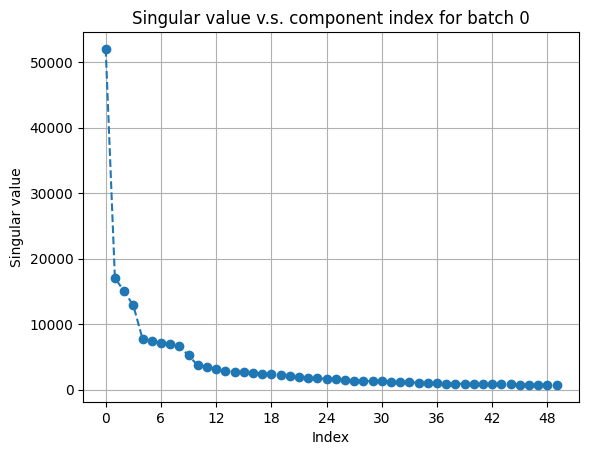

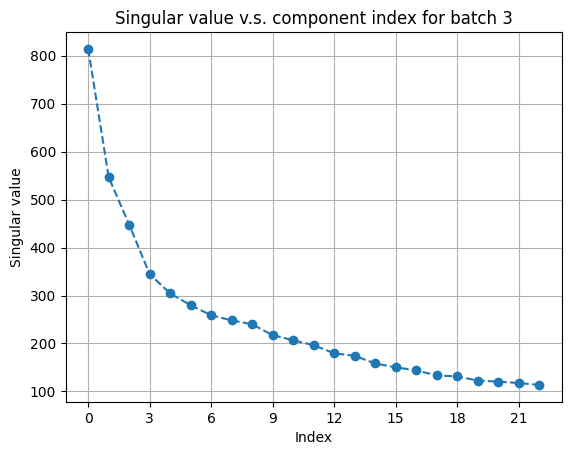

In [25]:
# Plot singular values to determine SVD components
# fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# plt.sca(axes[0])
fusor.plot_singular_values(target='active_arr1', n_components=50)
# axes[0].set_title('RNA Active - Singular Values')

# plt.sca(axes[1])
fusor.plot_singular_values(target='active_arr2', n_components=min(23, protein_active.shape[1]-1))
# axes[1].set_title('Protein Active - Singular Values')

# plt.tight_layout()
# plt.show()

In [26]:
# Set SVD components based on data dimensions
# NOTE: Parameters adjusted for 59-marker PhenoCycler dataset (vs original 26-marker CODEX)
n_prot_features = protein_active.shape[1]
n_rna_features = rna_active.shape[1]
n_shared = rna_shared.shape[1]

# Graph construction: higher SVD for protein to capture richer 59-marker structure
svd_comp1_graph = min(50, n_rna_features - 1)  # RNA: increased from 40 to 50
svd_comp2_graph = min(30, n_prot_features - 1)  # Protein: increased from 15 to 30 for 59 markers

print(f"Graph construction SVD components:")
print(f"  RNA: {svd_comp1_graph}")
print(f"  Protein: {svd_comp2_graph}")
print(f"  (Protein features: {n_prot_features})")


Graph construction SVD components:
  RNA: 50
  Protein: 30
  (Protein features: 40)


In [27]:
# Construct graphs with automatic clustering
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=svd_comp1_graph,
    svd_components2=svd_comp2_graph,
    resolution1=2.0,   # Higher resolution = more clusters = finer smoothing
    resolution2=2.0,
    resolution_tol=0.1,
    leiden_runs=1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Now at batch 3...
Now at batch 4...
Now at batch 5...
Now at batch 6...
Now at batch 7...
Now at batch 8...
Now at batch 9...
Now at batch 10...
Now at batch 11...
Now at batch 12...
Now at batch 13...
Now at batch 14...
Now at batch 15...
Now at batch 16...
Now at batch 17...
Now at batch 18...
Now at batch 19...
Now at batch 20...
Now at batch 21...
Now at batch 22...
Now at batch 23...
Now at batch 24...
Now at batch 25...
Now at batch 26...
Now at batch 2

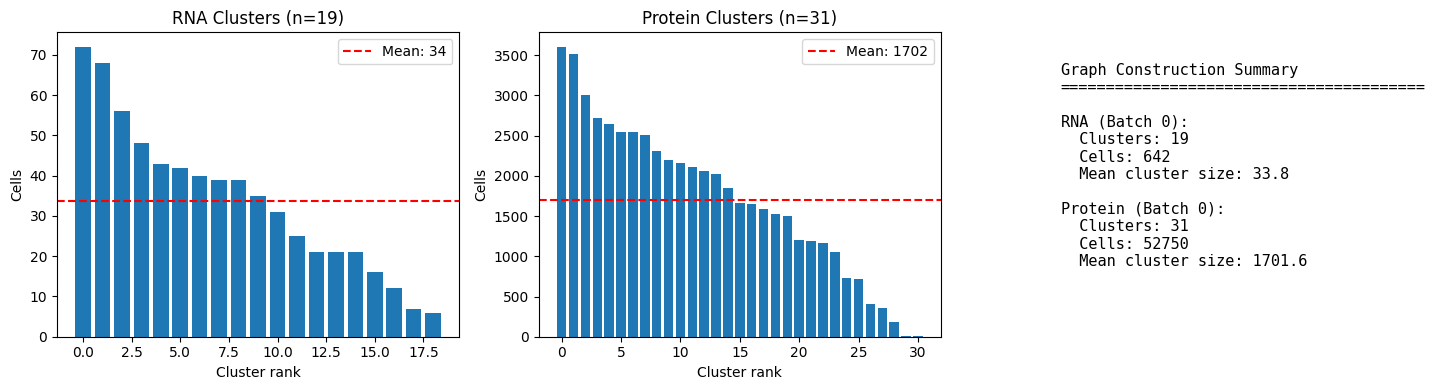

In [28]:
# Visualize clustering results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Get cluster labels from first batch
labels1_b0 = fusor._labels1[0]
labels2_b0 = fusor._labels2[0]

# RNA cluster sizes
ax = axes[0]
unique, counts = np.unique(labels1_b0, return_counts=True)
ax.bar(range(len(counts)), sorted(counts, reverse=True))
ax.set_xlabel('Cluster rank')
ax.set_ylabel('Cells')
ax.set_title(f'RNA Clusters (n={len(unique)})')
ax.axhline(y=np.mean(counts), color='r', linestyle='--', label=f'Mean: {np.mean(counts):.0f}')
ax.legend()

# Protein cluster sizes
ax = axes[1]
unique, counts = np.unique(labels2_b0, return_counts=True)
ax.bar(range(len(counts)), sorted(counts, reverse=True))
ax.set_xlabel('Cluster rank')
ax.set_ylabel('Cells')
ax.set_title(f'Protein Clusters (n={len(unique)})')
ax.axhline(y=np.mean(counts), color='r', linestyle='--', label=f'Mean: {np.mean(counts):.0f}')
ax.legend()

# Summary stats
ax = axes[2]
ax.axis('off')
stats_text = f'''Graph Construction Summary
{"="*40}

RNA (Batch 0):
  Clusters: {len(np.unique(labels1_b0))}
  Cells: {len(labels1_b0)}
  Mean cluster size: {np.mean(np.bincount(labels1_b0)):.1f}

Protein (Batch 0):
  Clusters: {len(np.unique(labels2_b0))}
  Cells: {len(labels2_b0)}
  Mean cluster size: {np.mean(np.bincount(labels2_b0)):.1f}
'''
ax.text(0.1, 0.9, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

In [29]:
# Find initial pivots with smoothing for weak linkage
# NOTE: Reduced SVD components (from 25/20) to prevent noise fitting in weak linkage scenario
# Initial matching uses ONLY shared features (~26), so fewer components = more robust seeds
svd_shared1 = min(20, n_shared - 1)  # Reduced from 25 to 20
svd_shared2 = min(18, n_shared - 1)  # Reduced from 20 to 18
print(f"Using {svd_shared1}/{svd_shared2} SVD components for shared features")
print(f"  (n_shared = {n_shared})")

fusor.find_initial_pivots(
    wt1=0.3,  # Smoothing weight
    wt2=0.3,
    svd_components1=svd_shared1,
    svd_components2=svd_shared2,
    verbose=True
)


Using 20/18 SVD components for shared features
  (n_shared = 37)
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 0<->6...
Now at batch 0<->7...
Now at batch 0<->8...
Now at batch 0<->9...
Now at batch 0<->10...
Now at batch 0<->11...
Now at batch 0<->12...
Now at batch 0<->13...
Now at batch 0<->14...
Now at batch 0<->15...
Now at batch 0<->16...
Now at batch 0<->17...
Now at batch 0<->18...
Now at batch 0<->19...
Now at batch 0<->20...
Now at batch 0<->21...
Now at batch 0<->22...
Now at batch 0<->23...
Now at batch 0<->24...
Now at batch 0<->25...
Now at batch 0<->26...
Now at batch 0<->27...
Now at batch 0<->28...
Now at batch 0<->29...
Now at batch 0<->30...
Now at batch 0<->31...
Now at batch 0<->32...
Done!


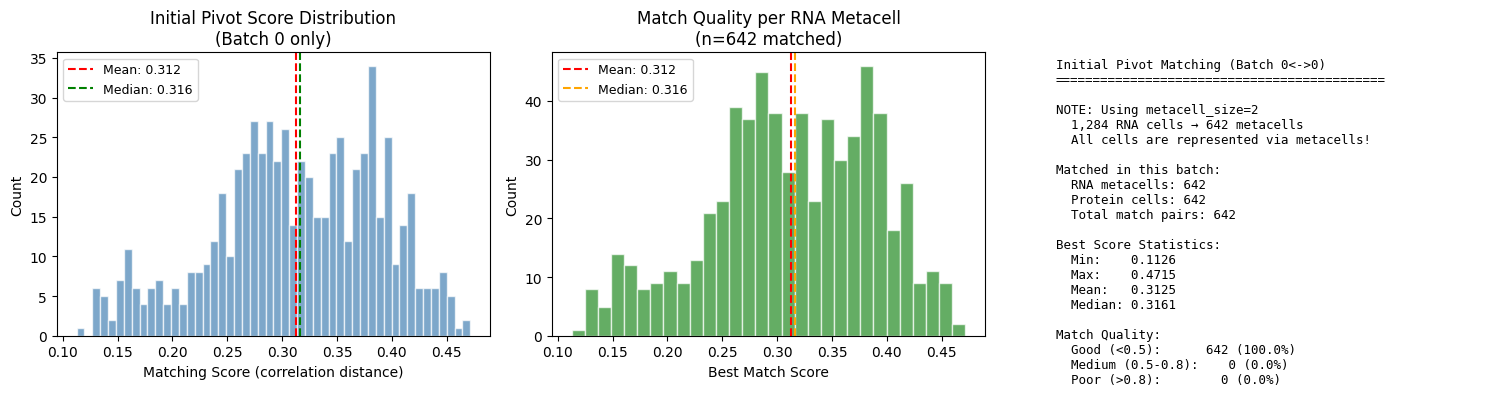


Total batches: 33
Total matches across all batches: 21,186

Metacell aggregation: 1284 cells → ~642 metacells
All RNA cells are represented through their metacells.


In [33]:
# Visualize initial pivot matching
# NOTE: Initial matching operates on METACELLS, not individual cells
# With metacell_size=2, ~1284 cells become ~642 metacells

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Get initial matching from first batch (batch 0<->0)
init_match = fusor._init_matching[0]
init_rows, init_cols, init_scores = init_match

# Determine if metacells were used
using_metacells = fusor.metacell_size > 1
n_metacells = len(np.unique(init_rows)) if using_metacells else None

# Plot 1: Score distribution
ax = axes[0]
ax.hist(init_scores, bins=50, edgecolor='white', alpha=0.7, color='steelblue')
ax.axvline(np.mean(init_scores), color='r', linestyle='--', 
           label=f'Mean: {np.mean(init_scores):.3f}')
ax.axvline(np.median(init_scores), color='g', linestyle='--',
           label=f'Median: {np.median(init_scores):.3f}')
ax.set_xlabel('Matching Score (correlation distance)')
ax.set_ylabel('Count')
ax.set_title('Initial Pivot Score Distribution\n(Batch 0 only)')
ax.legend(fontsize=9)

# Plot 2: Best score per RNA metacell/cell
ax = axes[1]
unique_rna = np.unique(init_rows)
best_scores = []
for rna_idx in unique_rna:
    mask = init_rows == rna_idx
    best_scores.append(np.min(init_scores[mask]))
best_scores = np.array(best_scores)

ax.hist(best_scores, bins=30, edgecolor='white', alpha=0.7, color='forestgreen')
ax.axvline(np.mean(best_scores), color='r', linestyle='--',
           label=f'Mean: {np.mean(best_scores):.3f}')
ax.axvline(np.median(best_scores), color='orange', linestyle='--',
           label=f'Median: {np.median(best_scores):.3f}')
ax.set_xlabel('Best Match Score')
ax.set_ylabel('Count')
unit = 'Metacell' if using_metacells else 'Cell'
ax.set_title(f'Match Quality per RNA {unit}\n(n={len(unique_rna):,} matched)')
ax.legend(fontsize=9)

# Plot 3: Summary statistics
ax = axes[2]
ax.axis('off')

n_matched = len(unique_rna)
n_rna_total = rna_shared.shape[0]
n_prot_matched = len(np.unique(init_cols))

# Categorize match quality
good = (best_scores < 0.5).sum()
medium = ((best_scores >= 0.5) & (best_scores < 0.8)).sum()
poor = (best_scores >= 0.8).sum()

if using_metacells:
    metacell_note = f"""
NOTE: Using metacell_size={fusor.metacell_size}
  {n_rna_total:,} RNA cells → {n_matched:,} metacells
  All cells are represented via metacells!
"""
else:
    metacell_note = ""

stats = f"""Initial Pivot Matching (Batch 0<->0)
{"="*44}
{metacell_note}
Matched in this batch:
  RNA {"metacells" if using_metacells else "cells"}: {n_matched:,}
  Protein cells: {n_prot_matched:,}
  Total match pairs: {len(init_scores):,}

Best Score Statistics:
  Min:    {np.min(best_scores):.4f}
  Max:    {np.max(best_scores):.4f}
  Mean:   {np.mean(best_scores):.4f}
  Median: {np.median(best_scores):.4f}

Match Quality:
  Good (<0.5):     {good:>4} ({good/n_matched*100:.1f}%)
  Medium (0.5-0.8): {medium:>4} ({medium/n_matched*100:.1f}%)
  Poor (>0.8):     {poor:>4} ({poor/n_matched*100:.1f}%)
"""
ax.text(0.02, 0.98, stats, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

# Print info about all batches
print(f"\nTotal batches: {len(fusor._init_matching)}")
total_matches = sum(len(m[0]) for m in fusor._init_matching)
print(f"Total matches across all batches: {total_matches:,}")
if using_metacells:
    print(f"\nMetacell aggregation: {n_rna_total} cells → ~{n_rna_total // fusor.metacell_size} metacells")
    print("All RNA cells are represented through their metacells.")


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Canonical correlation v.s. component index for batch 0<->32'}, xlabel='Index', ylabel='Canonical correlation'>)

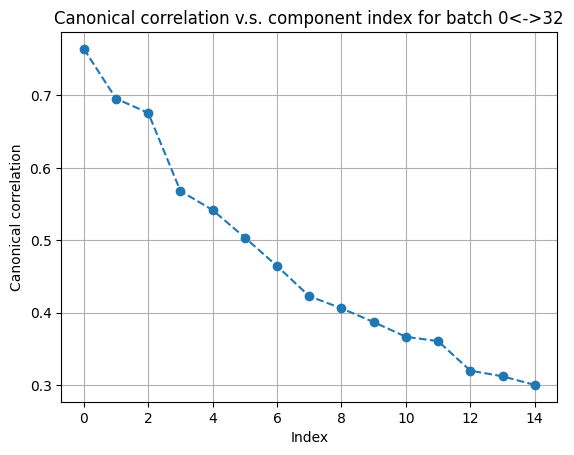

In [34]:
# Check canonical correlations
# Use same SVD limits as refine_pivots
cca_comp_check = min(15, n_prot_features - 1)
fusor.plot_canonical_correlations(
    svd_components1=min(50, n_rna_features - 1),   # Match refine_pivots
    svd_components2=min(35, n_prot_features - 1),  # Match refine_pivots
    cca_components=cca_comp_check
)


In [35]:
# Refine pivots using CCA
# CRITICAL: CCA component selection for 59-marker dataset
# Too many components = overfitting, especially with more protein features than RNA samples
# Rule: min(n_shared - 1, sqrt(n_protein_active) + 1, hard_cap)

n_prot_active = n_prot_features - n_shared  # Active protein features not in shared set
cca_components = min(
    n_shared - 1,                    # Can't exceed shared features
    int(np.sqrt(n_prot_active)) + 1, # sqrt rule for overfitting prevention
    12                               # Hard cap (increased from previous 25 which was too high)
)
cca_components = max(5, cca_components)  # At least 5 components

print(f"CCA components: {cca_components}")
print(f"  (n_shared={n_shared}, n_prot_active={n_prot_active}, sqrt rule={int(np.sqrt(n_prot_active))+1})")

# SVD before CCA: reduce dimensionality to prevent CCA overfitting
svd_cca_rna = min(50, n_rna_features - 1)     # Increased from 40 to 50
svd_cca_prot = min(35, n_prot_features - 1)   # NEW: limit protein SVD (was None = keep all)

print(f"SVD before CCA: RNA={svd_cca_rna}, Protein={svd_cca_prot}")

fusor.refine_pivots(
    wt1=0.3,
    wt2=0.3,
    svd_components1=svd_cca_rna,
    svd_components2=svd_cca_prot,  # Now limited instead of None
    cca_components=cca_components,
    n_iters=1,
    filter_prop=0.0,
    verbose=True
)


CCA components: 5
  (n_shared=37, n_prot_active=3, sqrt rule=2)
SVD before CCA: RNA=50, Protein=35
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 0<->6...
Now at batch 0<->7...
Now at batch 0<->8...
Now at batch 0<->9...
Now at batch 0<->10...
Now at batch 0<->11...
Now at batch 0<->12...
Now at batch 0<->13...
Now at batch 0<->14...
Now at batch 0<->15...
Now at batch 0<->16...
Now at batch 0<->17...
Now at batch 0<->18...
Now at batch 0<->19...
Now at batch 0<->20...
Now at batch 0<->21...
Now at batch 0<->22...
Now at batch 0<->23...
Now at batch 0<->24...
Now at batch 0<->25...
Now at batch 0<->26...
Now at batch 0<->27...
Now at batch 0<->28...
Now at batch 0<->29...
Now at batch 0<->30...
Now at batch 0<->31...
Now at batch 0<->32...
Done!


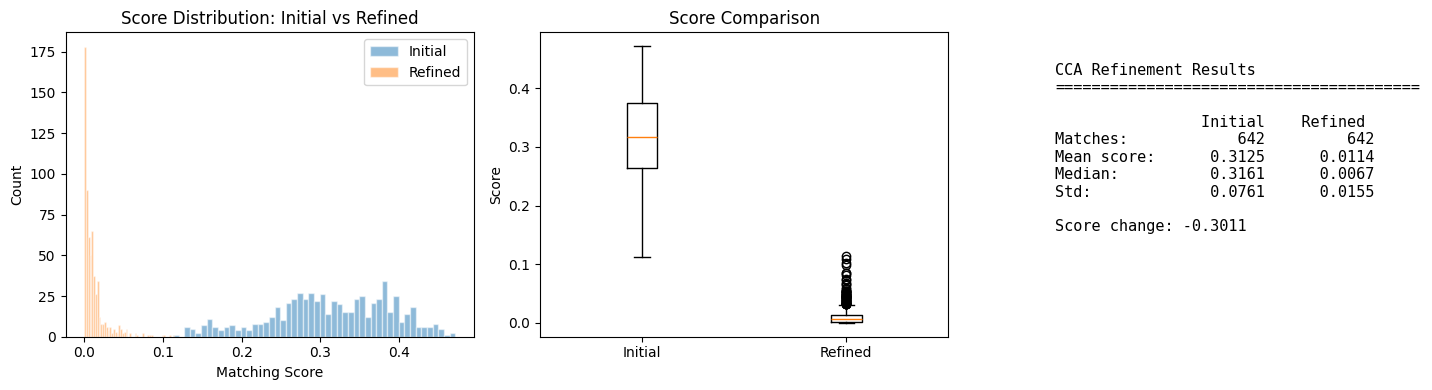

In [36]:
# Compare initial vs refined matching
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Get refined matching
refined_match = fusor._refined_matching[0]
ref_rows, ref_cols, ref_scores = refined_match

# Score comparison
ax = axes[0]
ax.hist(init_scores, bins=50, alpha=0.5, label='Initial', edgecolor='white')
ax.hist(ref_scores, bins=50, alpha=0.5, label='Refined', edgecolor='white')
ax.set_xlabel('Matching Score')
ax.set_ylabel('Count')
ax.set_title('Score Distribution: Initial vs Refined')
ax.legend()

# Score improvement
ax = axes[1]
ax.boxplot([init_scores, ref_scores], labels=['Initial', 'Refined'])
ax.set_ylabel('Score')
ax.set_title('Score Comparison')

# Summary
ax = axes[2]
ax.axis('off')
stats = f'''CCA Refinement Results
{"="*40}

                Initial    Refined
Matches:     {len(init_scores):>10,}  {len(ref_scores):>10,}
Mean score:  {np.mean(init_scores):>10.4f}  {np.mean(ref_scores):>10.4f}
Median:      {np.median(init_scores):>10.4f}  {np.median(ref_scores):>10.4f}
Std:         {np.std(init_scores):>10.4f}  {np.std(ref_scores):>10.4f}

Score change: {np.mean(ref_scores) - np.mean(init_scores):+.4f}
'''
ax.text(0.1, 0.9, stats, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

GMM Analysis of Pivot Matching Scores
Mode 1 (good): mean=0.006, std=0.006, weight=83.0%
Mode 2 (bad):  mean=0.036, std=0.023, weight=17.0%

Recommended filter_prop: 0.17 (fraction in bad mode)
Threshold between modes: 0.021


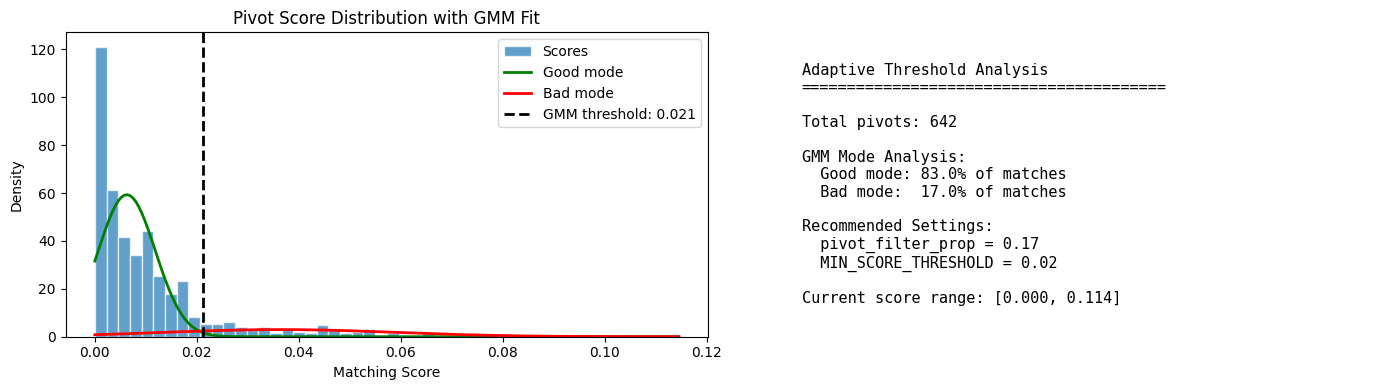

In [37]:
# Analyze pivot score distribution with Gaussian Mixture Model
# This helps identify bimodal distribution and set adaptive thresholds
from sklearn.mixture import GaussianMixture

# Get pivot matching scores from refined matching
pivot_match = fusor._refined_matching[0]  # First batch
pivot_scores = np.array(pivot_match[2])

# Fit Gaussian Mixture to detect two modes
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(pivot_scores.reshape(-1, 1))
means = gmm.means_.flatten()
weights = gmm.weights_
stds = np.sqrt(gmm.covariances_.flatten())

# Identify good vs bad mode (lower score = better match for distance-based)
good_mode_idx = np.argmin(means)
bad_mode_idx = np.argmax(means)

print("GMM Analysis of Pivot Matching Scores")
print("=" * 50)
print(f"Mode 1 (good): mean={means[good_mode_idx]:.3f}, std={stds[good_mode_idx]:.3f}, weight={weights[good_mode_idx]:.1%}")
print(f"Mode 2 (bad):  mean={means[bad_mode_idx]:.3f}, std={stds[bad_mode_idx]:.3f}, weight={weights[bad_mode_idx]:.1%}")

# Threshold at midpoint between modes
gmm_threshold = (means[0] + means[1]) / 2
bad_mode_fraction = weights[bad_mode_idx]

print(f"\nRecommended filter_prop: {bad_mode_fraction:.2f} (fraction in bad mode)")
print(f"Threshold between modes: {gmm_threshold:.3f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histogram with GMM fit
ax = axes[0]
x = np.linspace(pivot_scores.min(), pivot_scores.max(), 200)
ax.hist(pivot_scores, bins=50, density=True, alpha=0.7, edgecolor='white', label='Scores')

# Plot GMM components
from scipy.stats import norm
for i in range(2):
    color = 'green' if i == good_mode_idx else 'red'
    label = 'Good mode' if i == good_mode_idx else 'Bad mode'
    ax.plot(x, weights[i] * norm.pdf(x, means[i], stds[i]), 
            color=color, linewidth=2, label=label)

ax.axvline(gmm_threshold, color='black', linestyle='--', linewidth=2, label=f'GMM threshold: {gmm_threshold:.3f}')
ax.set_xlabel('Matching Score')
ax.set_ylabel('Density')
ax.set_title('Pivot Score Distribution with GMM Fit')
ax.legend()

# Score ranges
ax = axes[1]
ax.axis('off')
summary = f'''Adaptive Threshold Analysis
{"="*40}

Total pivots: {len(pivot_scores):,}

GMM Mode Analysis:
  Good mode: {weights[good_mode_idx]:.1%} of matches
  Bad mode:  {weights[bad_mode_idx]:.1%} of matches

Recommended Settings:
  pivot_filter_prop = {bad_mode_fraction:.2f}
  MIN_SCORE_THRESHOLD = {gmm_threshold:.2f}

Current score range: [{pivot_scores.min():.3f}, {pivot_scores.max():.3f}]
'''
ax.text(0.1, 0.9, summary, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

In [38]:
# Filter bad pivots using GMM-guided threshold
# The GMM analysis (previous cell) identifies the fraction of matches in the "bad mode"
# Use that fraction (with a small margin) instead of a fixed 20%

# GMM-guided filtering: use bad_mode_fraction from previous cell
# Add small margin (0.02) to be slightly conservative, cap at 0.2 max
pivot_filter_prop = min(0.2, bad_mode_fraction + 0.02)

print(f"GMM-guided pivot filter:")
print(f"  Bad mode fraction: {bad_mode_fraction:.2%}")
print(f"  Filter proportion: {pivot_filter_prop:.2%} (bad_mode + 2% margin, max 20%)")

fusor.filter_bad_matches(
    target='pivot',
    filter_prop=pivot_filter_prop,
    verbose=True
)

print(f"\nFiltered {pivot_filter_prop*100:.1f}% of lowest-scoring pivots")

GMM-guided pivot filter:
  Bad mode fraction: 17.00%
  Filter proportion: 19.00% (bad_mode + 2% margin, max 20%)
Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 0<->6...
Now at batch 0<->7...
Now at batch 0<->8...
Now at batch 0<->9...
Now at batch 0<->10...
Now at batch 0<->11...
Now at batch 0<->12...
Now at batch 0<->13...
Now at batch 0<->14...
Now at batch 0<->15...
Now at batch 0<->16...
Now at batch 0<->17...
Now at batch 0<->18...
Now at batch 0<->19...
Now at batch 0<->20...
Now at batch 0<->21...
Now at batch 0<->22...
Now at batch 0<->23...
Now at batch 0<->24...
Now at batch 0<->25...
Now at batch 0<->26...
Now at batch 0<->27...
Now at batch 0<->28...
Now at batch 0<->29...
Now at batch 0<->30...
Now at batch 0<->31...
Now at batch 0<->32...
17160/21186 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
1284/1

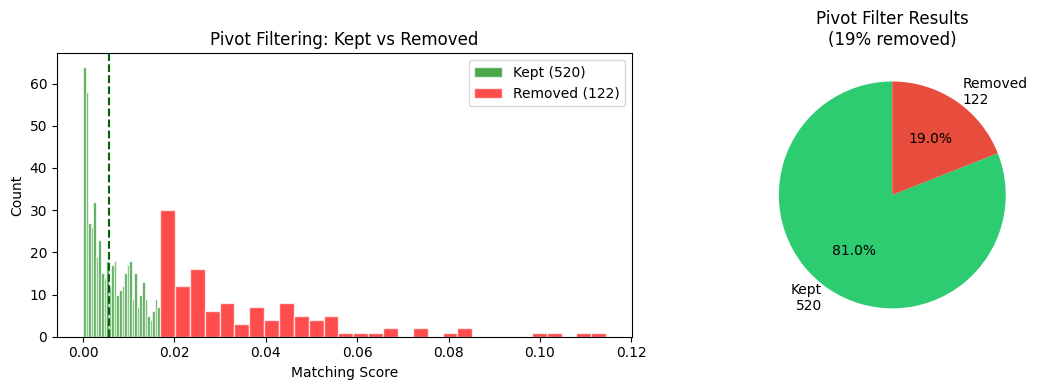

Pivot filtering: 520 kept, 122 removed
Mean score - Kept: 0.0056, Removed: 0.0358


In [39]:
# Visualize pivot filtering results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Get remaining indices
remaining_idx = fusor._remaining_indices_in_refined_matching[0]
kept_scores = ref_scores[remaining_idx]
removed_scores = np.delete(ref_scores, remaining_idx)

# Score distributions: kept vs removed
ax = axes[0]
ax.hist(kept_scores, bins=30, alpha=0.7, label=f'Kept ({len(kept_scores)})', color='green', edgecolor='white')
if len(removed_scores) > 0:
    ax.hist(removed_scores, bins=30, alpha=0.7, label=f'Removed ({len(removed_scores)})', color='red', edgecolor='white')
ax.axvline(np.mean(kept_scores), color='darkgreen', linestyle='--')
ax.set_xlabel('Matching Score')
ax.set_ylabel('Count')
ax.set_title('Pivot Filtering: Kept vs Removed')
ax.legend()

# Summary pie chart
ax = axes[1]
sizes = [len(kept_scores), len(removed_scores)]
labels = [f'Kept\n{len(kept_scores):,}', f'Removed\n{len(removed_scores):,}']
colors = ['#2ecc71', '#e74c3c']
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
pct_removed = 100 * len(removed_scores) / (len(kept_scores) + len(removed_scores))
ax.set_title(f'Pivot Filter Results\n({pct_removed:.0f}% removed)')

plt.tight_layout()
plt.show()

print(f"Pivot filtering: {len(kept_scores):,} kept, {len(removed_scores):,} removed")
if len(removed_scores) > 0:
    print(f"Mean score - Kept: {np.mean(kept_scores):.4f}, Removed: {np.mean(removed_scores):.4f}")
else:
    print(f"Mean score - Kept: {np.mean(kept_scores):.4f}")


In [40]:
# Propagate to all cells
# Use same SVD limits as refine_pivots for consistency
fusor.propagate(
    svd_components1=min(50, n_rna_features - 1),   # Increased from 40 to 50
    svd_components2=min(35, n_prot_features - 1),  # NEW: limit protein SVD (was None)
    wt1=0.7,
    wt2=0.7,
    verbose=True
)


Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 0<->6...
Now at batch 0<->7...
Now at batch 0<->8...
Now at batch 0<->9...
Now at batch 0<->10...
Now at batch 0<->11...
Now at batch 0<->12...
Now at batch 0<->13...
Now at batch 0<->14...
Now at batch 0<->15...
Now at batch 0<->16...
Now at batch 0<->17...
Now at batch 0<->18...
Now at batch 0<->19...
Now at batch 0<->20...
Now at batch 0<->21...
Now at batch 0<->22...
Now at batch 0<->23...
Now at batch 0<->24...
Now at batch 0<->25...
Now at batch 0<->26...
Now at batch 0<->27...
Now at batch 0<->28...
Now at batch 0<->29...
Now at batch 0<->30...
Now at batch 0<->31...
Now at batch 0<->32...
Done!


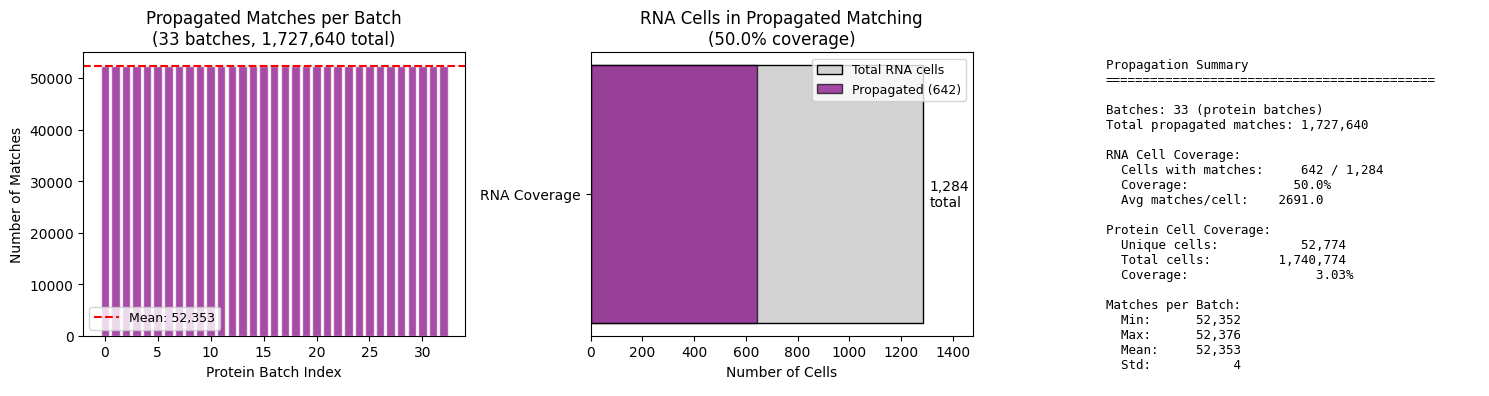

In [47]:
# Visualize propagation results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Collect propagation data from all batches
matches_per_batch = []
all_prop_rows = []
all_prop_cols = []
for batch_match in fusor._propagated_matching:
    rows, cols, scores = batch_match
    matches_per_batch.append(len(rows))
    all_prop_rows.extend(rows)
    all_prop_cols.extend(cols)
all_prop_rows = np.array(all_prop_rows)
all_prop_cols = np.array(all_prop_cols)

# Plot 1: Matches per protein batch (always informative)
ax = axes[0]
n_batches = len(matches_per_batch)
batch_nums = np.arange(n_batches)
bars = ax.bar(batch_nums, matches_per_batch, color='purple', edgecolor='white', alpha=0.7)
ax.axhline(np.mean(matches_per_batch), color='r', linestyle='--', 
           label=f'Mean: {np.mean(matches_per_batch):,.0f}')
ax.set_xlabel('Protein Batch Index')
ax.set_ylabel('Number of Matches')
ax.set_title(f'Propagated Matches per Batch\n({n_batches} batches, {sum(matches_per_batch):,} total)')
ax.legend(fontsize=9)
# Only show every 5th tick if many batches
if n_batches > 10:
    ax.set_xticks(batch_nums[::5])

# Plot 2: RNA cell coverage comparison
ax = axes[1]

# Count unique RNA cells matched via propagation
prop_rna_unique = len(np.unique(all_prop_rows))
total_rna = rna_active.shape[0]

# For comparison, show what we started with from pivots
# (pivots alone don't cover all RNA cells; propagation fills gaps)
pivot_only = total_rna - prop_rna_unique  # Cells only from pivots
overlap = prop_rna_unique  # Cells covered by propagation

# Stacked bar showing coverage sources
categories = ['RNA Coverage']
ax.barh(categories, [total_rna], color='lightgray', edgecolor='black', label='Total RNA cells')
ax.barh(categories, [prop_rna_unique], color='purple', edgecolor='black', alpha=0.7, 
        label=f'Propagated ({prop_rna_unique:,})')

ax.set_xlabel('Number of Cells')
ax.set_xlim(0, total_rna * 1.15)
ax.legend(loc='upper right', fontsize=9)
ax.set_title(f'RNA Cells in Propagated Matching\n({100*prop_rna_unique/total_rna:.1f}% coverage)')

# Add text annotation
ax.text(total_rna * 1.02, 0, f'{total_rna:,}\ntotal', va='center', fontsize=10)

# Plot 3: Summary statistics
ax = axes[2]
ax.axis('off')

prop_prot_unique = len(np.unique(all_prop_cols))
total_prot = protein_active.shape[0]

# Calculate matches per RNA cell
rna_match_counts = np.bincount(all_prop_rows, minlength=total_rna)
rna_with_matches = (rna_match_counts > 0).sum()
avg_matches_per_rna = rna_match_counts[rna_match_counts > 0].mean() if rna_with_matches > 0 else 0

stats = f"""Propagation Summary
{"="*44}

Batches: {n_batches} (protein batches)
Total propagated matches: {sum(matches_per_batch):,}

RNA Cell Coverage:
  Cells with matches: {rna_with_matches:>7,} / {total_rna:,}
  Coverage:           {100*rna_with_matches/total_rna:>7.1f}%
  Avg matches/cell:   {avg_matches_per_rna:>7.1f}

Protein Cell Coverage:
  Unique cells:       {prop_prot_unique:>10,}
  Total cells:        {total_prot:>10,}
  Coverage:           {100*prop_prot_unique/total_prot:>10.2f}%

Matches per Batch:
  Min:    {min(matches_per_batch):>8,}
  Max:    {max(matches_per_batch):>8,}
  Mean:   {np.mean(matches_per_batch):>8,.0f}
  Std:    {np.std(matches_per_batch):>8,.0f}
"""
ax.text(0.02, 0.98, stats, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()


In [48]:
# Filter propagated matches
# NOTE: Using more conservative filtering (5%) to maximize coverage
# The pivot filtering already removed poor matches; be gentle here
propagate_filter_prop = 0.05  # Remove bottom 5% (was 10%)

fusor.filter_bad_matches(
    target='propagated',
    filter_prop=propagate_filter_prop,
    verbose=True
)

print(f"\nFiltered {propagate_filter_prop*100:.0f}% of lowest-scoring propagated matches")

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 0<->6...
Now at batch 0<->7...
Now at batch 0<->8...
Now at batch 0<->9...
Now at batch 0<->10...
Now at batch 0<->11...
Now at batch 0<->12...
Now at batch 0<->13...
Now at batch 0<->14...
Now at batch 0<->15...
Now at batch 0<->16...
Now at batch 0<->17...
Now at batch 0<->18...
Now at batch 0<->19...
Now at batch 0<->20...
Now at batch 0<->21...
Now at batch 0<->22...
Now at batch 0<->23...
Now at batch 0<->24...
Now at batch 0<->25...
Now at batch 0<->26...
Now at batch 0<->27...
Now at batch 0<->28...
Now at batch 0<->29...
Now at batch 0<->30...
Now at batch 0<->31...
Now at batch 0<->32...
1641245/1727640 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!

Filtered 5% of lowest-scoring propagated matches


In [49]:
# Get full matching - RNA-CENTRIC
# order=(1,2) ensures each RNA cell gets at least one protein match
# This gives ~1,284 matches (one per RNA) instead of ~1.7M (one per protein)
full_matching = fusor.get_matching(order=(1, 2), target='full_data')

print(f"\nMaxFuse Full matching results (RNA-centric):")
print(f"  Total matches: {len(full_matching[0])}")
print(f"  Unique RNA cells: {len(np.unique(full_matching[0]))}")
print(f"  Unique Protein cells: {len(np.unique(full_matching[1]))}")
print(f"  Score range: [{min(full_matching[2]):.3f}, {max(full_matching[2]):.3f}]")


MaxFuse Full matching results (RNA-centric):
  Total matches: 1284
  Unique RNA cells: 1284
  Unique Protein cells: 1057
  Score range: [0.172, 1.000]


Score threshold filtering (min score >= 0.0):
  Original matches: 1,284
  Removed (score < 0.0): 0 (0.0%)
  Remaining matches: 1,284

Score statistics after filtering:
  Min:    0.1715
  Max:    0.9998
  Mean:   0.9396
  Median: 0.9652


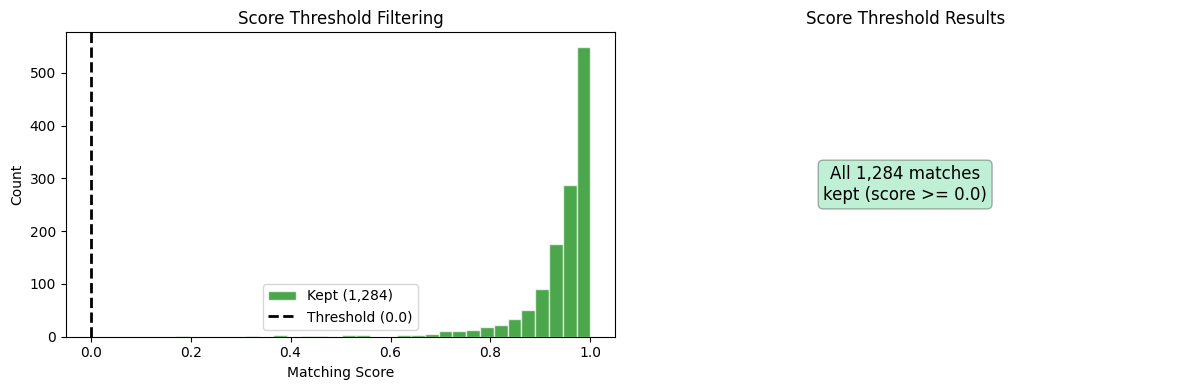

In [50]:
# Apply score threshold to remove negative/low-quality matches
MIN_SCORE_THRESHOLD = 0.0  # Remove anti-correlated matches only

# Get original stats
n_original = len(full_matching[0])
scores = np.array(full_matching[2])

# Filter by threshold
mask = scores >= MIN_SCORE_THRESHOLD
full_matching_filtered = (
    np.array(full_matching[0])[mask],
    np.array(full_matching[1])[mask],
    scores[mask]
)

n_filtered = len(full_matching_filtered[0])
n_removed = n_original - n_filtered

print(f"Score threshold filtering (min score >= {MIN_SCORE_THRESHOLD}):")
print(f"  Original matches: {n_original:,}")
print(f"  Removed (score < {MIN_SCORE_THRESHOLD}): {n_removed:,} ({100*n_removed/n_original:.1f}%)")
print(f"  Remaining matches: {n_filtered:,}")
print(f"")
print(f"Score statistics after filtering:")
print(f"  Min:    {np.min(full_matching_filtered[2]):.4f}")
print(f"  Max:    {np.max(full_matching_filtered[2]):.4f}")
print(f"  Mean:   {np.mean(full_matching_filtered[2]):.4f}")
print(f"  Median: {np.median(full_matching_filtered[2]):.4f}")

# Update full_matching to use filtered version
full_matching = full_matching_filtered

# Visualize what was removed
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
if n_removed > 0:
    ax.hist(scores[~mask], bins=30, alpha=0.7, color='red', label=f'Removed ({n_removed:,})', edgecolor='white')
ax.hist(scores[mask], bins=30, alpha=0.7, color='green', label=f'Kept ({n_filtered:,})', edgecolor='white')
ax.axvline(MIN_SCORE_THRESHOLD, color='black', linestyle='--', linewidth=2, label=f'Threshold ({MIN_SCORE_THRESHOLD})')
ax.set_xlabel('Matching Score')
ax.set_ylabel('Count')
ax.set_title('Score Threshold Filtering')
ax.legend()

ax = axes[1]
if n_removed > 0:
    sizes = [n_filtered, n_removed]
    colors = ['#2ecc71', '#e74c3c']
    labels = [f'Kept\n{n_filtered:,}', f'Removed\n{n_removed:,}']
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.set_title('Score Threshold Results')
else:
    ax.text(0.5, 0.5, f'All {n_filtered:,} matches\nkept (score >= {MIN_SCORE_THRESHOLD})', 
            ha='center', va='center', fontsize=12, transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='#2ecc71', alpha=0.3))
    ax.set_title('Score Threshold Results')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [51]:
# Verify matching cardinality (RNA-centric approach)
print("=" * 60)
print("MATCHING CARDINALITY VERIFICATION (RNA-CENTRIC)")
print("=" * 60)

n_total_matches = len(full_matching[0])
n_unique_rna = len(np.unique(full_matching[0]))
n_unique_protein = len(np.unique(full_matching[1]))

print(f"Total matches: {n_total_matches:,}")
print(f"Unique RNA matched: {n_unique_rna:,} / {rna_active.shape[0]} ({100*n_unique_rna/rna_active.shape[0]:.1f}%)")
print(f"Unique protein matched: {n_unique_protein:,} / {protein_active.shape[0]} ({100*n_unique_protein/protein_active.shape[0]:.1f}%)")
print(f"")
print(f"Score range: [{full_matching[2].min():.3f}, {full_matching[2].max():.3f}]")
print(f"Mean score: {full_matching[2].mean():.3f}")
print(f"")

# With RNA-centric matching, we expect ~1 match per RNA cell
avg_matches_per_rna = n_total_matches / n_unique_rna if n_unique_rna > 0 else 0
print(f"Avg matches per RNA: {avg_matches_per_rna:.1f}")

# Check RNA coverage
rna_coverage = n_unique_rna / rna_active.shape[0] * 100
if rna_coverage >= 90:
    print(f"\n✓ Good RNA coverage ({rna_coverage:.1f}%)")
else:
    print(f"\n⚠️  Low RNA coverage ({rna_coverage:.1f}%) - some RNA cells unmatched")

MATCHING CARDINALITY VERIFICATION (RNA-CENTRIC)
Total matches: 1,284
Unique RNA matched: 1,284 / 1284 (100.0%)
Unique protein matched: 1,057 / 1740774 (0.1%)

Score range: [0.172, 1.000]
Mean score: 0.940

Avg matches per RNA: 1.0

✓ Good RNA coverage (100.0%)


In [52]:
# Investigate unmatched RNA cells
# Validate that score filtering was applied (cell 57 must run first)
assert np.min(full_matching[2]) >= MIN_SCORE_THRESHOLD, \
    f"Run the score filtering cell first! Found scores below {MIN_SCORE_THRESHOLD} in full_matching."

print("=" * 60)
print("UNMATCHED RNA CELL ANALYSIS")
print("=" * 60)

# Find matched and unmatched RNA cells
matched_rna_idx = np.unique(full_matching[0])
all_rna_idx = np.arange(rna_active.shape[0])
unmatched_rna_idx = np.setdiff1d(all_rna_idx, matched_rna_idx)

n_matched = len(matched_rna_idx)
n_unmatched = len(unmatched_rna_idx)
n_total = rna_active.shape[0]

print(f"\nRNA Cell Coverage:")
print(f"  Matched:   {n_matched:,} ({100*n_matched/n_total:.1f}%)")
print(f"  Unmatched: {n_unmatched:,} ({100*n_unmatched/n_total:.1f}%)")
print(f"  Total:     {n_total:,}")

# Save unmatched indices for further analysis
unmatched_rna_indices = unmatched_rna_idx

if n_unmatched == 0:
    print("\n*** All RNA cells matched! ***")
    print("No unmatched analysis needed.")
else:
    # Compare feature distributions: matched vs unmatched
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Shared feature means
    ax = axes[0, 0]
    matched_shared_mean = rna_shared[matched_rna_idx].mean(axis=1)
    unmatched_shared_mean = rna_shared[unmatched_rna_idx].mean(axis=1)
    ax.hist(matched_shared_mean, bins=30, alpha=0.6, label='Matched', color='green', density=True)
    ax.hist(unmatched_shared_mean, bins=30, alpha=0.6, label='Unmatched', color='red', density=True)
    ax.set_xlabel('Mean z-scored expression')
    ax.set_ylabel('Density')
    ax.set_title('Shared Features (z-scored): Matched vs Unmatched')
    ax.legend()

    # Shared feature variance
    ax = axes[0, 1]
    matched_shared_var = rna_shared[matched_rna_idx].var(axis=1)
    unmatched_shared_var = rna_shared[unmatched_rna_idx].var(axis=1)
    ax.hist(matched_shared_var, bins=30, alpha=0.6, label='Matched', color='green', density=True)
    ax.hist(unmatched_shared_var, bins=30, alpha=0.6, label='Unmatched', color='red', density=True)
    ax.set_xlabel('Variance of shared features')
    ax.set_ylabel('Density')
    ax.set_title('Feature Variance: Matched vs Unmatched')
    ax.legend()

    # Detection rate (non-zero features)
    ax = axes[0, 2]
    # Use detection mask from normalization (non-zero after log1p)
    matched_detection = rna_detection_mask[matched_rna_idx].mean(axis=1)
    unmatched_detection = rna_detection_mask[unmatched_rna_idx].mean(axis=1)
    ax.hist(matched_detection, bins=30, alpha=0.6, label='Matched', color='green', density=True)
    ax.hist(unmatched_detection, bins=30, alpha=0.6, label='Unmatched', color='red', density=True)
    ax.set_xlabel('Fraction of detected features')
    ax.set_ylabel('Density')
    ax.set_title('Detection Rate: Matched vs Unmatched')
    ax.legend()

    # Active feature mean
    ax = axes[1, 0]
    matched_active_mean = rna_active[matched_rna_idx].mean(axis=1)
    unmatched_active_mean = rna_active[unmatched_rna_idx].mean(axis=1)
    ax.hist(matched_active_mean, bins=30, alpha=0.6, label='Matched', color='green', density=True)
    ax.hist(unmatched_active_mean, bins=30, alpha=0.6, label='Unmatched', color='red', density=True)
    ax.set_xlabel('Mean active feature value')
    ax.set_ylabel('Density')
    ax.set_title('Active Features: Matched vs Unmatched')
    ax.legend()

    # Active feature variance  
    ax = axes[1, 1]
    matched_active_var = rna_active[matched_rna_idx].var(axis=1)
    unmatched_active_var = rna_active[unmatched_rna_idx].var(axis=1)
    ax.hist(matched_active_var, bins=30, alpha=0.6, label='Matched', color='green', density=True)
    ax.hist(unmatched_active_var, bins=30, alpha=0.6, label='Unmatched', color='red', density=True)
    ax.set_xlabel('Variance of active features')
    ax.set_ylabel('Density')
    ax.set_title('Active Variance: Matched vs Unmatched')
    ax.legend()

    # Summary statistics
    ax = axes[1, 2]
    ax.axis('off')

    # Statistical comparison
    from scipy import stats
    t_stat_shared, p_shared = stats.ttest_ind(matched_shared_mean, unmatched_shared_mean)
    t_stat_detect, p_detect = stats.ttest_ind(matched_detection, unmatched_detection)

    summary = f"""Unmatched Cell Characteristics
{"="*45}

Shared feature mean:
  Matched:   {np.mean(matched_shared_mean):.4f}
  Unmatched: {np.mean(unmatched_shared_mean):.4f}
  p-value:   {p_shared:.2e}

Detection rate:
  Matched:   {np.mean(matched_detection):.2%}
  Unmatched: {np.mean(unmatched_detection):.2%}
  p-value:   {p_detect:.2e}

Interpretation:
"""

    if np.mean(unmatched_detection) < np.mean(matched_detection) - 0.05:
        summary += "  Unmatched cells have LOWER detection\n"
        summary += "  (sparse profiles harder to match)"
    elif np.mean(unmatched_shared_mean) < np.mean(matched_shared_mean) - 0.1:
        summary += "  Unmatched cells have LOWER expression\n"
        summary += "  (low signal harder to match)"
    else:
        summary += "  No clear pattern - may be cell type\n"
        summary += "  specific (check clustering)"

    ax.text(0.05, 0.95, summary, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

    plt.tight_layout()
    plt.show()

print(f"\nUnmatched RNA cell indices saved to 'unmatched_rna_indices'")
print(f"Use these indices to investigate in notebook 3 (visualization)")


UNMATCHED RNA CELL ANALYSIS

RNA Cell Coverage:
  Matched:   1,284 (100.0%)
  Unmatched: 0 (0.0%)
  Total:     1,284

*** All RNA cells matched! ***
No unmatched analysis needed.

Unmatched RNA cell indices saved to 'unmatched_rna_indices'
Use these indices to investigate in notebook 3 (visualization)


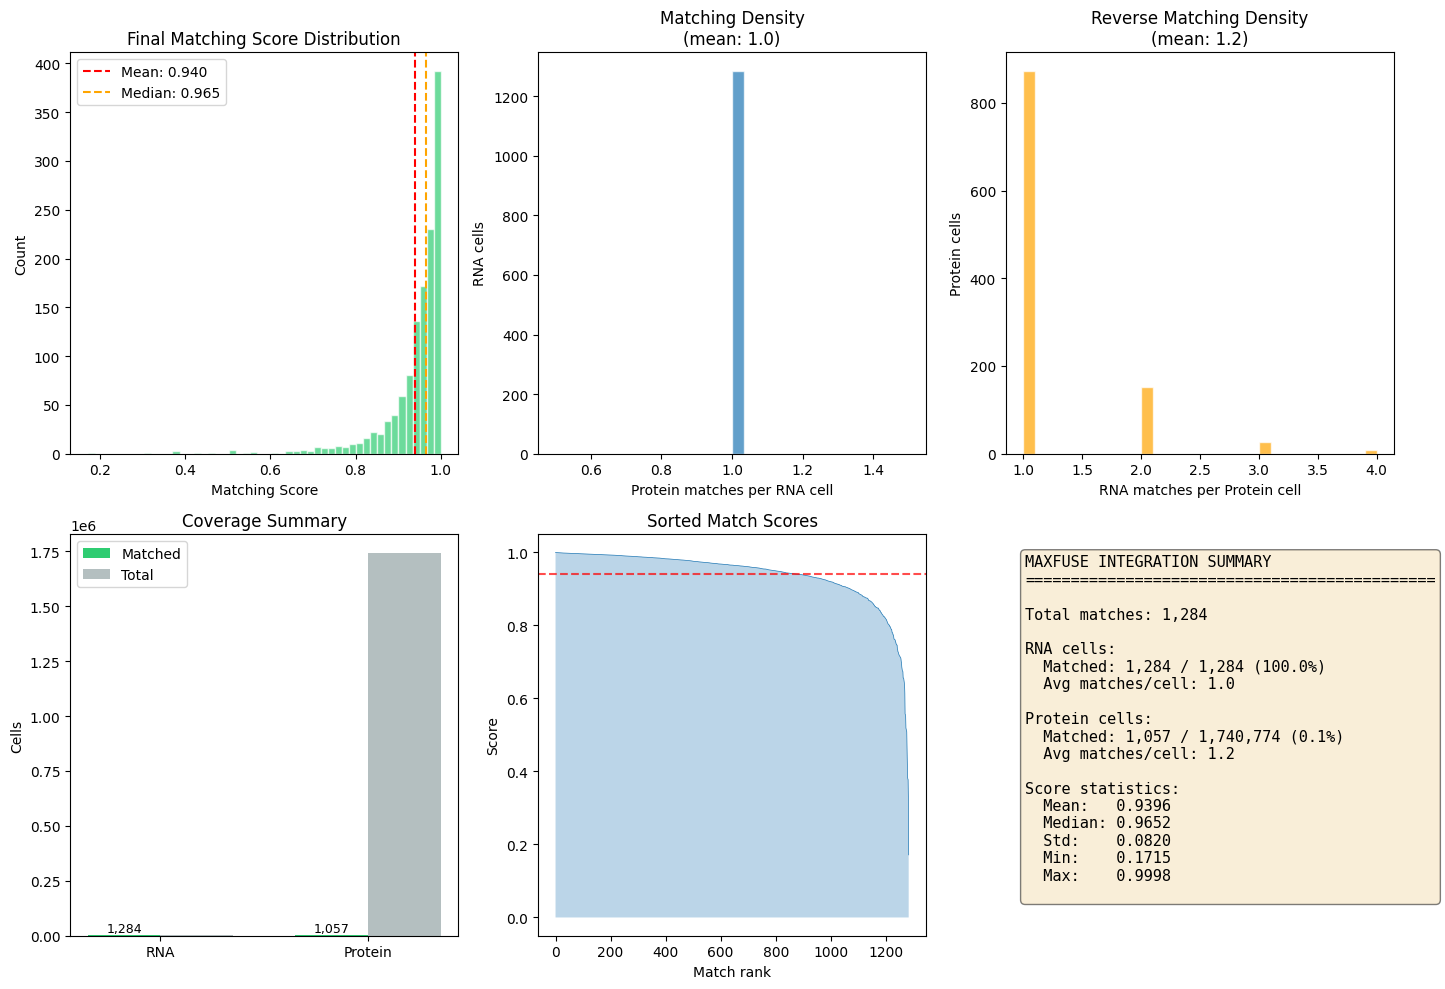

In [53]:
# Comprehensive final matching visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Score distribution
ax = axes[0, 0]
ax.hist(full_matching[2], bins=50, edgecolor='white', alpha=0.7, color='#2ecc71')
ax.axvline(np.mean(full_matching[2]), color='r', linestyle='--',
           label=f'Mean: {np.mean(full_matching[2]):.3f}')
ax.axvline(np.median(full_matching[2]), color='orange', linestyle='--',
           label=f'Median: {np.median(full_matching[2]):.3f}')
ax.set_xlabel('Matching Score')
ax.set_ylabel('Count')
ax.set_title('Final Matching Score Distribution')
ax.legend()

# Matches per RNA cell
ax = axes[0, 1]
rna_match_counts = np.bincount(full_matching[0], minlength=rna_active.shape[0])
ax.hist(rna_match_counts[rna_match_counts > 0], bins=30, edgecolor='white', alpha=0.7)
ax.set_xlabel('Protein matches per RNA cell')
ax.set_ylabel('RNA cells')
ax.set_title(f'Matching Density\n(mean: {np.mean(rna_match_counts[rna_match_counts > 0]):.1f})')

# Matches per Protein cell
ax = axes[0, 2]
prot_match_counts = np.bincount(full_matching[1], minlength=protein_active.shape[0])
ax.hist(prot_match_counts[prot_match_counts > 0], bins=30, edgecolor='white', alpha=0.7, color='orange')
ax.set_xlabel('RNA matches per Protein cell')
ax.set_ylabel('Protein cells')
ax.set_title(f'Reverse Matching Density\n(mean: {np.mean(prot_match_counts[prot_match_counts > 0]):.1f})')

# Coverage summary
ax = axes[1, 0]
n_rna_matched = len(np.unique(full_matching[0]))
n_prot_matched = len(np.unique(full_matching[1]))
categories = ['RNA', 'Protein']
matched = [n_rna_matched, n_prot_matched]
total = [rna_active.shape[0], protein_active.shape[0]]
x = np.arange(len(categories))
width = 0.35
bars1 = ax.bar(x - width/2, matched, width, label='Matched', color='#2ecc71')
bars2 = ax.bar(x + width/2, total, width, label='Total', color='#95a5a6', alpha=0.7)
ax.set_ylabel('Cells')
ax.set_title('Coverage Summary')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
for bar, val in zip(bars1, matched):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f'{val:,}', ha='center', va='bottom', fontsize=9)

# Score vs index (quality across matches)
ax = axes[1, 1]
sorted_scores = np.sort(full_matching[2])[::-1]
ax.plot(sorted_scores, linewidth=0.5)
ax.axhline(np.mean(full_matching[2]), color='r', linestyle='--', alpha=0.7)
ax.set_xlabel('Match rank')
ax.set_ylabel('Score')
ax.set_title('Sorted Match Scores')
ax.fill_between(range(len(sorted_scores)), sorted_scores, alpha=0.3)

# Final summary text
ax = axes[1, 2]
ax.axis('off')
coverage_rna = 100 * n_rna_matched / rna_active.shape[0]
coverage_prot = 100 * n_prot_matched / protein_active.shape[0]
summary = f'''MAXFUSE INTEGRATION SUMMARY
{"="*45}

Total matches: {len(full_matching[0]):,}

RNA cells:
  Matched: {n_rna_matched:,} / {rna_active.shape[0]:,} ({coverage_rna:.1f}%)
  Avg matches/cell: {len(full_matching[0])/n_rna_matched:.1f}

Protein cells:
  Matched: {n_prot_matched:,} / {protein_active.shape[0]:,} ({coverage_prot:.1f}%)
  Avg matches/cell: {len(full_matching[0])/n_prot_matched:.1f}

Score statistics:
  Mean:   {np.mean(full_matching[2]):.4f}
  Median: {np.median(full_matching[2]):.4f}
  Std:    {np.std(full_matching[2]):.4f}
  Min:    {np.min(full_matching[2]):.4f}
  Max:    {np.max(full_matching[2]):.4f}
'''
ax.text(0.05, 0.95, summary, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## Save Integration Results

Save integration outputs for use in subsequent visualization notebooks.

In [54]:
# Save integration results to results directory
import os
import pickle
from datetime import datetime
import json as json_module

# Create results directory
results_dir = '../results/2_integration'
os.makedirs(results_dir, exist_ok=True)

# Save matching results (filtered by score threshold)
matching_data = {
    'rna_indices': full_matching[0],
    'protein_indices': full_matching[1],
    'scores': full_matching[2]
}
with open(f'{results_dir}/maxfuse_matching.pkl', 'wb') as f:
    pickle.dump(matching_data, f)
print(f'Saved MaxFuse matching: {len(full_matching[0]):,} matches')

# Save as CSV for easy inspection
matching_df = pd.DataFrame({
    'rna_idx': full_matching[0],
    'protein_idx': full_matching[1],
    'score': full_matching[2]
})
matching_df.to_csv(f'{results_dir}/maxfuse_matching.csv', index=False)

# Save unmatched RNA indices for further analysis
np.save(f'{results_dir}/unmatched_rna_indices.npy', unmatched_rna_indices)
print(f'Saved unmatched RNA indices: {len(unmatched_rna_indices):,} cells')

# Save normalized arrays used for integration
np.save(f'{results_dir}/rna_shared.npy', rna_shared)
np.save(f'{results_dir}/rna_active.npy', rna_active)
np.save(f'{results_dir}/protein_shared.npy', protein_shared)
np.save(f'{results_dir}/protein_active.npy', protein_active)
print(f'Saved normalized arrays')

# Save correspondence table
correspondence_df = pd.DataFrame(
    rna_protein_correspondence, 
    columns=['rna_gene', 'protein_marker']
)
correspondence_df.to_csv(f'{results_dir}/correspondence.csv', index=False)

# Save integration parameters
n_matched_rna = len(np.unique(full_matching[0]))
n_matched_prot = len(np.unique(full_matching[1]))
integration_params = {
    'timestamp': datetime.now().isoformat(),
    'method': 'maxfuse',
    'score_threshold': MIN_SCORE_THRESHOLD,
    'fusor_params': {
        'max_outward_size': max_outward,
        'matching_ratio': matching_ratio,
        'smoothing_method': fusor.method,
        'n_shared_features': rna_shared.shape[1],
        'cca_components': cca_components,
        'pivot_filter_prop': pivot_filter_prop,
        'propagate_filter_prop': propagate_filter_prop
    },
    'data_shapes': {
        'rna_cells': rna_active.shape[0],
        'protein_cells': protein_active.shape[0],
        'rna_active_features': rna_active.shape[1],
        'protein_active_features': protein_active.shape[1],
        'shared_features': rna_shared.shape[1]
    },
    'matching_stats': {
        'total_matches': len(full_matching[0]),
        'unique_rna_matched': n_matched_rna,
        'unique_protein_matched': n_matched_prot,
        'rna_coverage_pct': 100 * n_matched_rna / rna_active.shape[0],
        'protein_coverage_pct': 100 * n_matched_prot / protein_active.shape[0],
        'unmatched_rna_cells': len(unmatched_rna_indices),
        'mean_score': float(np.mean(full_matching[2])),
        'min_score': float(np.min(full_matching[2])),
        'max_score': float(np.max(full_matching[2]))
    }
}
with open(f'{results_dir}/integration_params.json', 'w') as f:
    json_module.dump(integration_params, f, indent=2)

print(f'\nAll outputs saved to {results_dir}/')
print(f'  - maxfuse_matching.pkl (pickle)')
print(f'  - maxfuse_matching.csv')
print(f'  - unmatched_rna_indices.npy')
print(f'  - rna_shared.npy, rna_active.npy')
print(f'  - protein_shared.npy, protein_active.npy')
print(f'  - correspondence.csv')
print(f'  - integration_params.json')
print(f'\nRun 3_visualization.ipynb next.')


Saved MaxFuse matching: 1,284 matches
Saved unmatched RNA indices: 0 cells
Saved normalized arrays

All outputs saved to ../results/2_integration/
  - maxfuse_matching.pkl (pickle)
  - maxfuse_matching.csv
  - unmatched_rna_indices.npy
  - rna_shared.npy, rna_active.npy
  - protein_shared.npy, protein_active.npy
  - correspondence.csv
  - integration_params.json

Run 3_visualization.ipynb next.
